In [241]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import pymannkendall as mk
import pmdarima as pm
from pmdarima import auto_arima


from scipy import stats
import statsmodels.stats.diagnostic as stat
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VECM, VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")
import lxml

# Введение
**Данные**

In [194]:
wages = pd.read_csv('wages.csv')
unemployment = pd.read_csv('unemployment.csv')

In [3]:
unemployment.head(3)

,Dates,Bomji
0,1992-10,4.78
1,1992-11,4.80
2,1992-12,4.80


In [4]:
wages.head(3)

,Dates,Wages
0,1990-01,0
1,1990-02,0
2,1990-03,0


In [195]:
unemployment.columns = ['Dates', 'Unemployment']

unemployment['Dates'] = pd.to_datetime(unemployment['Dates'])
wages['Dates'] = pd.to_datetime(wages['Dates'])

In [6]:
unemployment

,Dates,Unemployment
0,1992-10-01,4.78
1,1992-11-01,4.80
2,1992-12-01,4.80
3,1993-01-01,4.89
4,1993-02-01,5.13
...,...,...
385,2024-11-01,2.30
386,2024-12-01,2.30
387,2025-01-01,2.40
388,2025-02-01,2.40


In [7]:
wages.head(20)

,Dates,Wages
0,1990-01-01,0
1,1990-02-01,0
2,1990-03-01,0
3,1990-04-01,0
4,1990-05-01,0
5,1990-06-01,0
6,1990-07-01,0
7,1990-08-01,0
8,1990-09-01,0
9,1990-10-01,0


In [196]:
wages = wages[wages['Dates'] >= '2000-01-01']
wages['Wages'] =np.log(wages['Wages']) 
unemployment = unemployment[unemployment['Dates'] >= '2000-01-01']

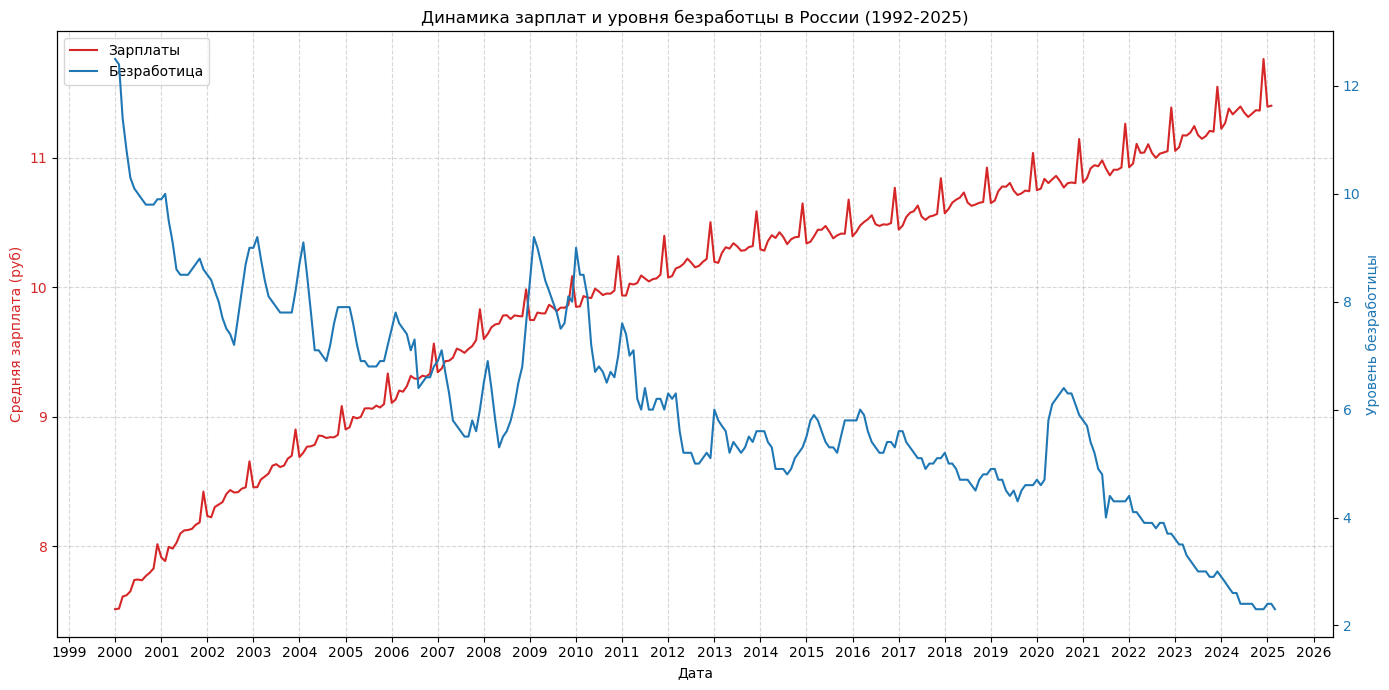

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Первый график - Зарплаты (левая ось Y)
color = 'tab:red'
ax1.set_xlabel('Дата')
ax1.set_ylabel('Средняя зарплата (руб)', color=color)
ax1.plot(wages['Dates'], wages['Wages'], color=color, label='Зарплаты')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.5)

# Вторая ось Y для уровня безработицы
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Уровень безработицы', color=color)
ax2.plot(unemployment['Dates'], unemployment['Unemployment'], color=color, label='Безработица')
ax2.tick_params(axis='y', labelcolor=color)

# Форматирование дат на оси X
ax1.xaxis.set_major_locator(mdates.YearLocator())  # Деления каждый год
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Формат "Год"

# Добавляем легенду
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Динамика зарплат и уровня безработцы в России (1992-2025)')
fig.tight_layout()
plt.show()

**ДОПОЛНИТЕЛЬНАЯ ЧАСТЬ РАБОТЫ**

Тесты на структурные сдвиги: Очень актуально для российских данных! Кризис 2008-2009, 2014-2015, Пандемия 2020, 2022. Используй:

Тест Чоу (Chow test): Если знаешь предполагаемую точку разлада (напр., апрель 2020).

Тест Кусила-Пагана (QLL - Quandt Likelihood Ratio) или supF: Если точка разлада неизвестна. Они просканируют ряд и найдут наиболее вероятную точку сдвига.

Анализ: Если сдвиг найден, можно включить дамми-переменную в ARIMA/VAR/VECM модели на этот период или оценить модели на подпериодах.

## Анализ графиков, выводы и гипотезы

- Безработица имеет нисходящий тренд, можно наблюдать аддитивные выбросы в 2009 и 2020 годах в связи с ...
- Заработные платы имеют восходящий тренд с сезонностью (12 месяцев). Это можно объяснить как ...

**Гипотезы**
- Гипотеза 1:...
- Гипотеза 2:...
- Гипотеза 3:...

# 1 ЭТАП

## Тест ADF и KPSS для двух рядов.

Спецификация с константой и трендом.

Отвергается ли гипотеза единичного корня?

## Формулировка гипотез

1. Тест Дики-Фуллера (ADF)
- H0: Ряд нестационарен (имеет единичный корень, т.е. содержит стохастический тренд).
- H1: Ряд стационарен (нет единичного корня).

2. Тест KPSS
- H0: Ряд стационарен (вокруг детерминированного тренда или константы).
- H1: Ряд нестационарен (имеет единичный корень).

Важно: ADF и KPSS проверяют противоположные гипотезы! Их результаты нужно анализировать совместно.

## Интерпретация результатов

1. Если ADF отвергает H0 (p-value < 0.05)
- Ряд стационарен (единичного корня нет).
- Можно использовать модели, предполагающие стационарность (ARMA, регрессия).
2. Если KPSS отвергает H0 (p-value < 0.05)
- Ряд нестационарен (есть единичный корень или тренд).
- Требуется дифференцирование или учет тренда.

## Совместный анализ ADF и KPSS

1. ADF (p-value) < 0.05 и KPSS (p-value) > 0.05:

  Ряд стационарен. Можно использовать ARIMA без дифференцирования (d=0).

2. ADF (p-value) > 0.05 и KPSS (p-value) < 0.05:

  Ряд нестационарен. Нужно дифференцировать (d=1,2) или учитывать тренд.

3. ADF (p-value) < 0.05 и KPSS (p-value) < 0.05:

  Противоречие. Возможно, ряд стационарен вокруг тренда (нужна модель с трендом).

4. ADF (p-value) > 0.05 и KPSS (p-value) > 0.05:

  Неопределенность. Проверьте другие тесты (например, PP-тест).



--------------------------------------
Уравнение (или более корректно SM модель) которое оценивается выглядит примерно так:

$ΔX_t=const+βt + φX_{t-1}+(θ_1ΔX_{t-1}+.... + θ_{p-1}ΔX_{t-p+1}) + e_t $

H0: $φ=0$ (те единичный корень есть) P.S: это не опечатка, что φ=0, а не φ=1, тк зависимая переменная в разности

H1: $φ<1$

Когда мы проводим тест adf с помошью встроенной-полукастомной функции adf_test(data[''], 'ct'), количество запаздывающих разностей (те вот эта часть $(θ_1ΔX_{t-1}+.... + θ_{p-1}ΔX_{t-p+1})$) подбирается автоматически на основе критериев bic или aic.
______________________________________

In [259]:
# Определяем границу разделения (последние 12 месяцев)
split_date = wages['Dates'].max() - pd.DateOffset(months=24)

# Разделяем данные
train = wages[wages['Dates'] <= split_date].copy()
test = wages[wages['Dates'] > split_date].copy()

print(f"Обучающая выборка: {train['Dates'].min()} - {train['Dates'].max()}")
print(f"Тестовая выборка: {test['Dates'].min()} - {test['Dates'].max()}")
print(f"Размеры: train={len(train)}, test={len(test)}")

Обучающая выборка: 2000-01-01 00:00:00 - 2023-02-01 00:00:00
Тестовая выборка: 2023-03-01 00:00:00 - 2025-02-01 00:00:00
Размеры: train=278, test=24


## Борьба с сезонностью (dami) - для з/п

In [11]:
# тест Дики-Фуллера
# немного отличается от стандартного вывода adfuller()
def adf_test(timeseries, regression, maxlag = None):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC',
                      store=False, regresults=False)
    results = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag='AIC',
                       store=True, regresults=True)[3].resols

    results.model.exog_names[0] = 'y(-1)'

    for item in range(dftest[2]):
        results.model.exog_names[item+1] = 'dy(' + str(-item-1) + ')'

    trend_len = regression.count('t')
    if trend_len > 0:
        for item in range(trend_len):
            results.model.exog_names[dftest[2]+item+2] = 'trend' + str(item+1)

    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    return results

In [12]:
# тест Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
def kpss_test(timeseries, regression, nlags = 'auto'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags = nlags)

    kpssoutput = pd.Series(
        kpsstest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value
    print(kpssoutput)

### Сначала применим тест Дики-Фуллера к исходному ряду

In [198]:
print(adf_test(wages['Wages'], 'ct').summary())

Results of Dickey-Fuller Test:
Test Statistic                  -2.399573
p-value                          0.379846
#Lags Used                      13.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.990553
Critical Value (5%)             -3.425845
Critical Value (10%)            -3.136076
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     632.6
Date:                Tue, 03 Jun 2025   Prob (F-statistic):          1.34e-201
Time:                        14:21:26   Log-Likelihood:                 721.24
No. Observations:                 288   AIC:                            -1410.
Df Residuals:                     272   BIC:                            -1352.
Df Model:                   

#### Отвергается ли гипотеза стационарности? - ДА, РЯД НЕСТАЦИОНАРЕН.

In [199]:
print(kpss_test(wages['Wages'], 'ct'))

Results of KPSS Test:
Test Statistic            0.63564
p-value                   0.01000
#Lags Used               10.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64
None


### Пробуем избавиться от сезонности с помощью дамми

In [200]:
dum = pd.get_dummies(train['Dates'].dt.month, dtype=float)
train = pd.concat([train, dum], axis=1)
train

,Dates,Wages,1,2,3,4,5,6,7,8,9,10,11,12
120,2000-01-01,7.512071,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,2000-02-01,7.516977,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,2000-03-01,7.609862,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,2000-04-01,7.620215,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,2000-05-01,7.650169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2022-10-01,11.042442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
394,2022-11-01,11.051842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
395,2022-12-01,11.390396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
396,2023-01-01,11.055008,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
# очистка от сезонности
mod_d = sm.tsa.statespace.SARIMAX(train['Wages'], trend='ct', order=(0,0,0), exog = dum)
results_d = mod_d.fit(disp = False)
print(results_d.summary())

                               SARIMAX Results                                
Dep. Variable:                  Wages   No. Observations:                  278
Model:                        SARIMAX   Log Likelihood                   0.622
Date:                Tue, 03 Jun 2025   AIC                             28.756
Time:                        14:15:18   BIC                             83.171
Sample:                             0   HQIC                            50.587
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5852      0.027    -59.070      0.000      -1.638      -1.533
drift          0.0114      0.000     57.142      0.000       0.011       0.012
1              9.7480      0.045    215.447      0.0

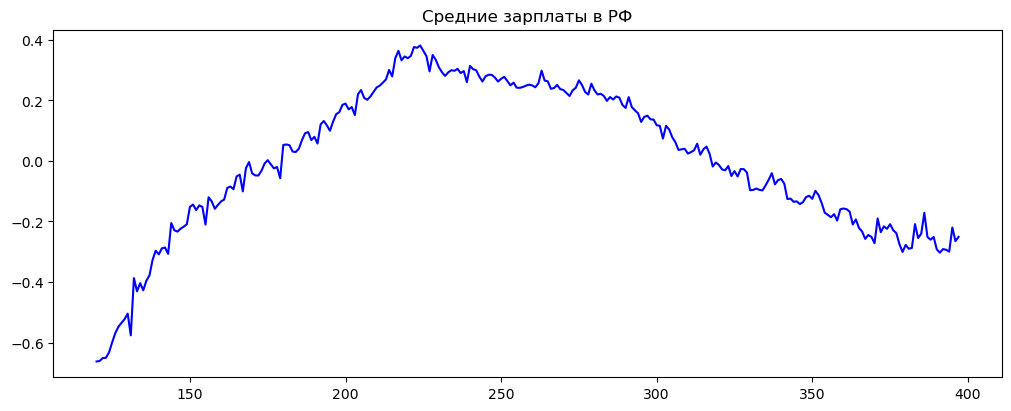

In [201]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.set(title='Средние зарплаты в РФ')
ax.plot(results_d.resid,'b-')

plt.show()

#### Посмотрим адф на очищенных данных

In [227]:
res_adf_d = adf_test(results_d.resid, 'ct')
print(res_adf_d.summary())

Results of Dickey-Fuller Test:
Test Statistic                  -2.412300
p-value                          0.373100
#Lags Used                      13.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.993477
Critical Value (5%)             -3.427252
Critical Value (10%)            -3.136901
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     23.61
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.47e-39
Time:                        14:39:46   Log-Likelihood:                 696.84
No. Observations:                 264   AIC:                            -1362.
Df Residuals:                     248   BIC:                            -1304.
Df Model:                   

- Тестовая статистика: -2.201245

- p-value: 0.489150 (> 0.05).

- -2.201245 > -3.425899 (для 5%) → ряд нестационарен.

Фактически, ряд демонстрирует сильную нестационарность (например, тренд, сезонность или случайное блуждание).136172

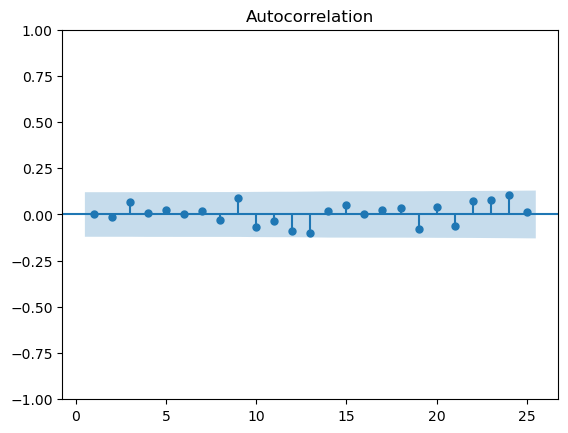

In [203]:
sm.graphics.tsa.plot_acf(res_adf_d.resid, zero = False)
plt.show()

In [204]:
# H0: нет корреляций в остатках
print('p-value =', np.round(bgtest(res_adf_d, nlags = 12)[1], 3))

p-value = 0.133


In [228]:
# H0: стационарность
print(kpss_test(res_adf_d.resid, 'ct'))

Results of KPSS Test:
Test Statistic           0.074773
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64
None


p-value=0.1 > 0.05 следовательно ряд зарплат нестационарный.

### Попробуем подобрать SARIMAX модель:

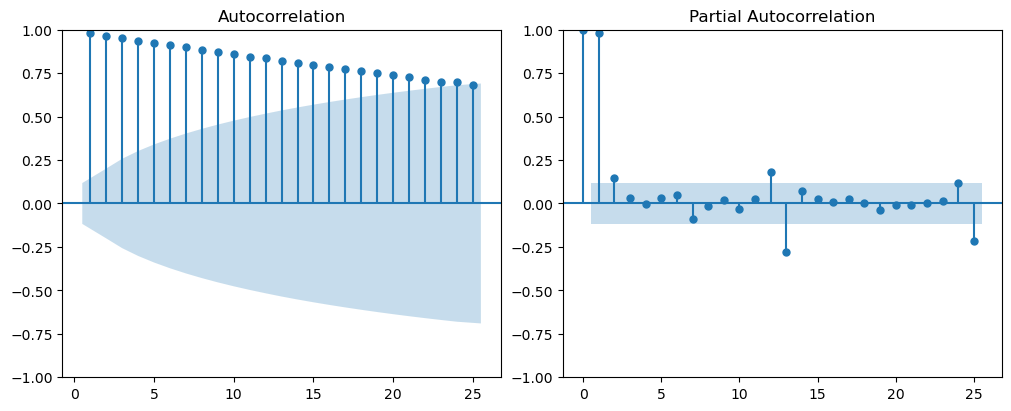

In [206]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(train['Wages'], ax = ax1, zero = False)
sm.graphics.tsa.plot_pacf(train['Wages'], method = 'ywm', ax = ax2)
plt.show()

На графике видно, что ACF медленно затухают, в то время, как PACF резко обрываются после двух выбросов-лучиков, а потом еще выходят за доверительный интервал спустя 12 месяцев и, возможно, спустя 24 месяца. Поэтому предположим, что здесь AR(2) + сезонные лаги.

In [211]:
mod_m = sm.tsa.statespace.SARIMAX(train['Wages'], trend='ct', order=(1,1,2), exog=dum)#, seasonal_order=(0,1,1,12))
results = mod_m.fit(disp = False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Wages   No. Observations:                  278
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 626.188
Date:                Tue, 03 Jun 2025   AIC                          -1216.377
Time:                        14:29:07   BIC                          -1151.144
Sample:                             0   HQIC                         -1190.203
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0411      0.004      9.328      0.000       0.032       0.050
drift         -0.0001   2.36e-05     -5.387      0.000      -0.000   -8.08e-05
1             -0.0595      0.006    -10.780      0.0

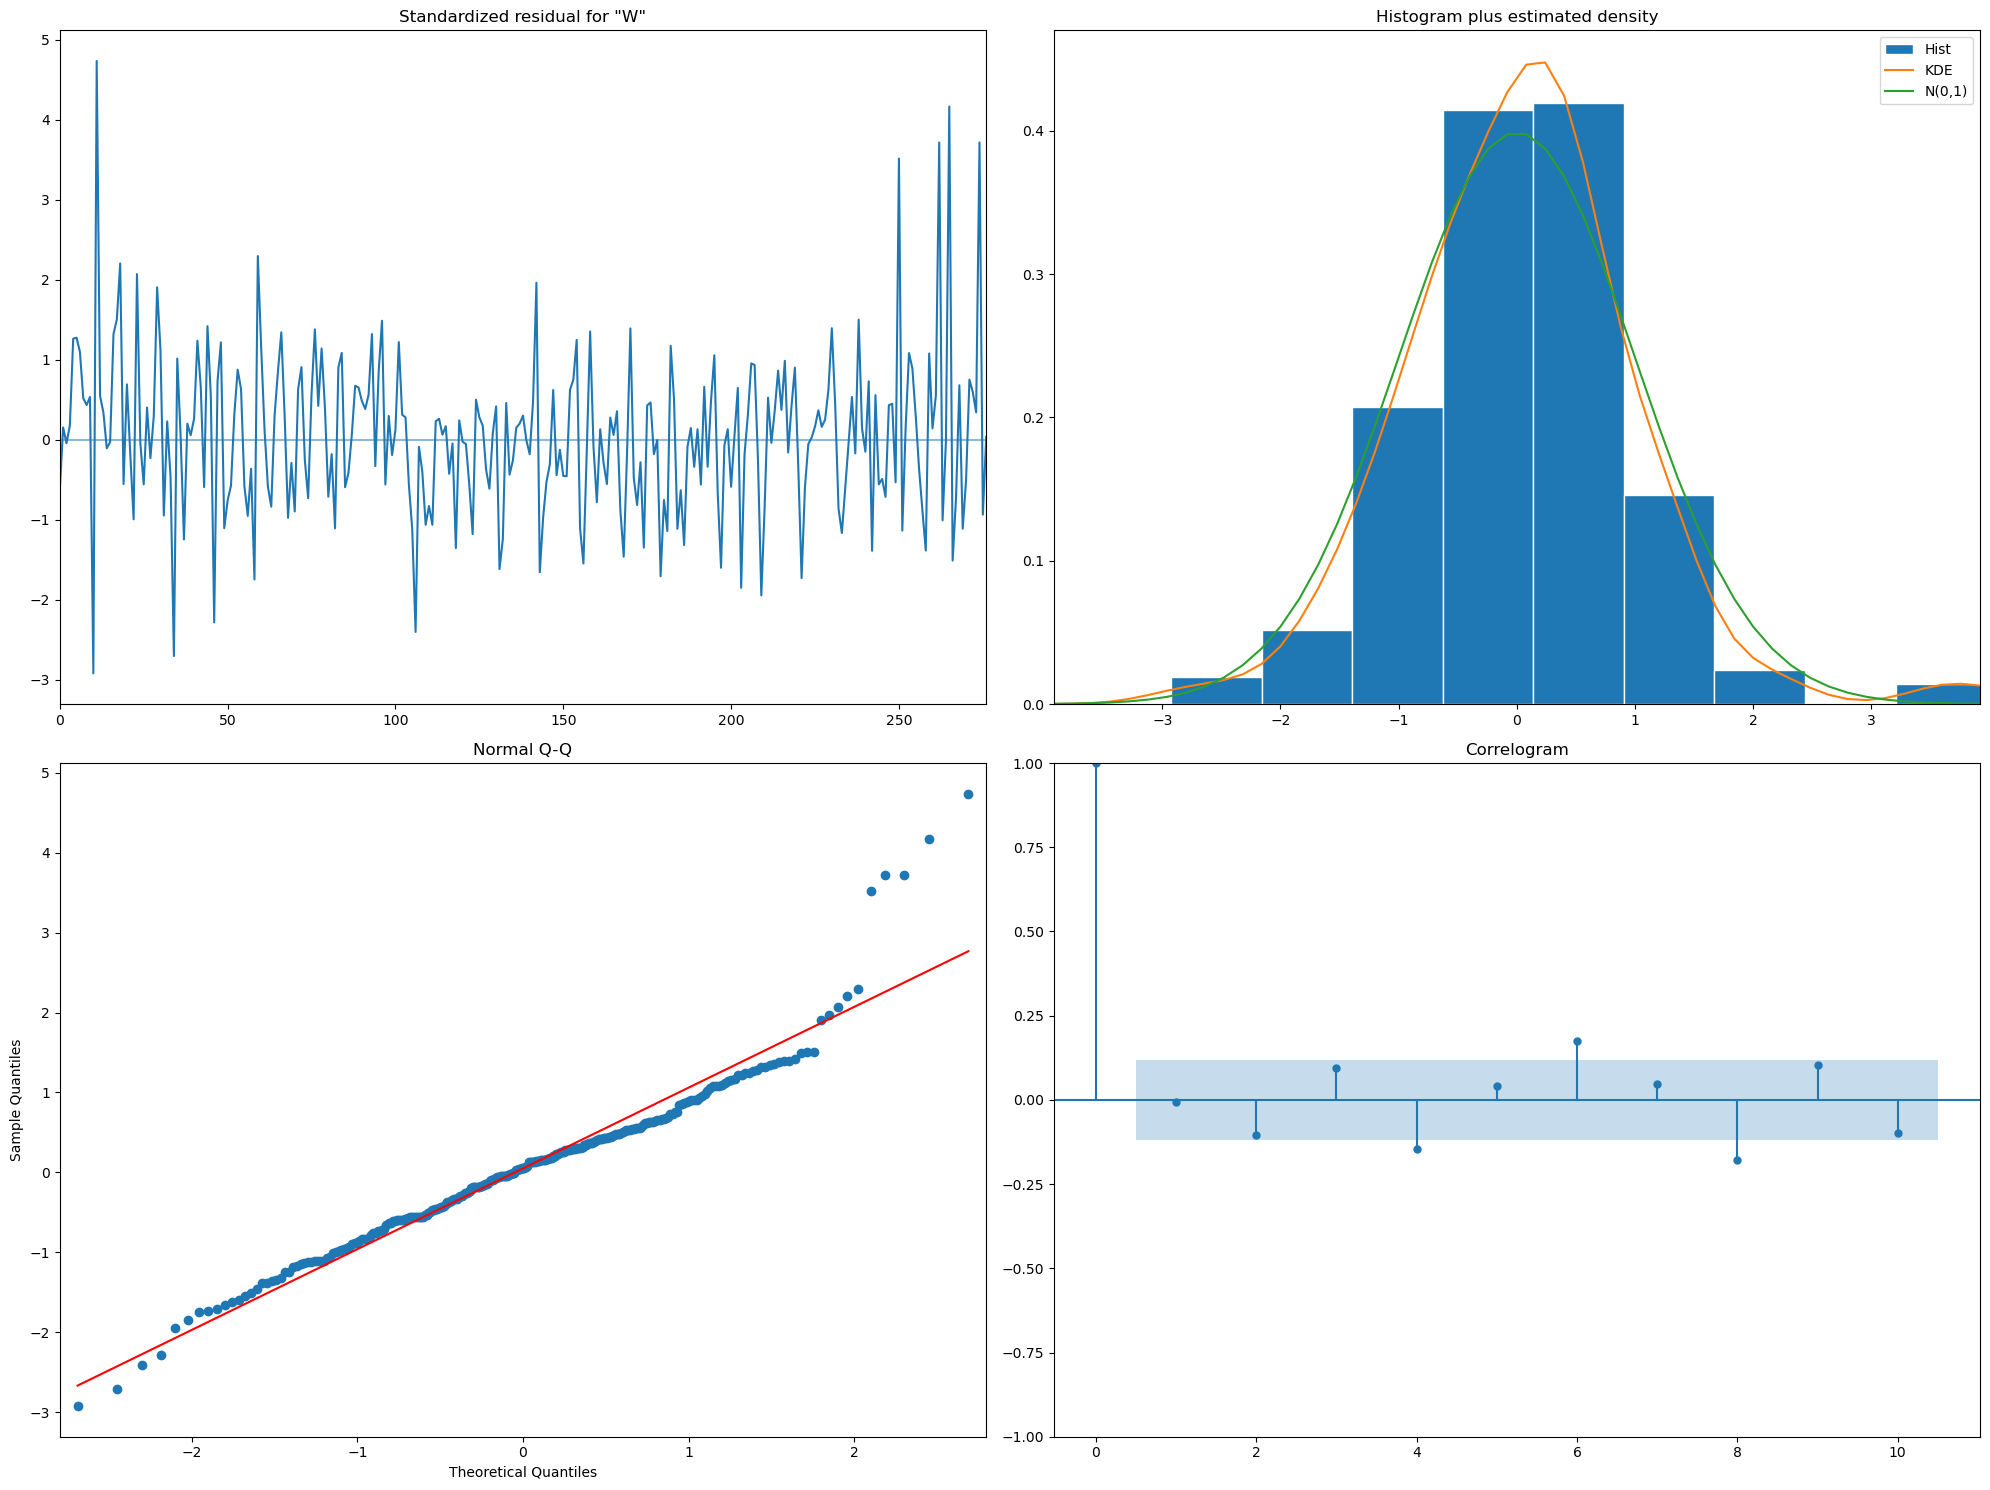

In [212]:
results.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

p-value = 0.542


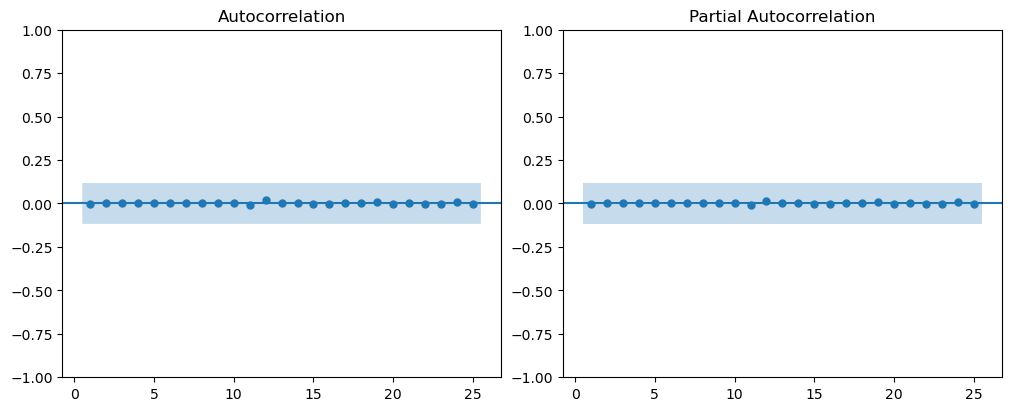

In [213]:
# H0: нет корреляций в остатках
print('p-value =', np.round(bgtest(results, nlags = 12)[1], 3))
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(results.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(results.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

Тест Бройша-Годфри не отвергает нулевую гипотезу об отсутствии корреляции в остатках (0.542 > 0.05) => остатки некоррелированы. 



### $ΔX_t= 0.0411 +0.0676ΔX_{t-1} + 0.9324ΔX_{t-2} +0.4879e_{t-1} -0.2741e_{t-2} + e_t$

**скорректировать коэффициенты**

## Для безработицы

Если присмотреться к графику, можно увидеть некоторую сезонность на определенных участках. Сезонная безработица как явление существует, и можно поискать в новостях, какой масштаб она принимает в РФ и стоит ли ее учитывать, если она не очень-то значима.
____________________________________________________________________________________

In [294]:
# Определяем границу разделения (последние 12 месяцев)
split_date = unemployment['Dates'].max() - pd.DateOffset(months=24)

# Разделяем данные
train = unemployment[unemployment['Dates'] <= split_date].copy()
test = unemployment[unemployment['Dates'] > split_date].copy()

print(f"Обучающая выборка: {train['Dates'].min()} - {train['Dates'].max()}")
print(f"Тестовая выборка: {test['Dates'].min()} - {test['Dates'].max()}")
print(f"Размеры: train={len(train)}, test={len(test)}")

Обучающая выборка: 2000-01-01 00:00:00 - 2023-03-01 00:00:00
Тестовая выборка: 2023-04-01 00:00:00 - 2025-03-01 00:00:00
Размеры: train=279, test=24


In [27]:
#H0: стационарность
kpss_test(train['Unemployment'], regression='ct')

Results of KPSS Test:
Test Statistic            0.143172
p-value                   0.055237
#Lags Used               10.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [28]:
# H0: единичный корень
adf_res = adf_test(train['Unemployment'], 'ct')
print(adf_res.summary())

Results of Dickey-Fuller Test:
Test Statistic                  -4.185951
p-value                          0.004701
#Lags Used                      12.000000
Number of Observations Used    266.000000
Critical Value (1%)             -3.993213
Critical Value (5%)             -3.427125
Critical Value (10%)            -3.136827
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.889
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.06e-15
Time:                        10:36:07   Log-Likelihood:                 6.0120
No. Observations:                 266   AIC:                             17.98
Df Residuals:                     251   BIC:                             71.73
Df Model:                   

------------------------------------------------------------------------------
Тестирование **без тренда**: p_value_KPSS < 0.05 (0.01) и p_value_ADF > 0.05 (0.667), следовательно, ряд нестационарен.

Протестируем p-value для ряда **с трендом**: p_value_KPSS > 0.05 (0.100) и p_value_ADF < 0.05 (0.010), получили стационарный ряд (ПРОВЕРИТЬ ЭТО СУЖДЕНИЕ).

### Попробуем подобрать SARIMAX модель:

Построим модель без сдвигов = > можем не строить тест вручную, подбирая лаги, а использовать кастомный ADF.

In [327]:
unemployment['COVID_dummy'] = 0
unemployment['2008_dummy'] = 0
unemployment.loc['2020-03-01':'2021-12-01', 'COVID_dummy'] = 1  # Помечаем период пандемии
unemployment.loc['2008-01-01':'2011-01-01', '2008_dummy'] = 1
unemployment

,Dates,Unemployment,COVID_dummy,2008_dummy
87,2000-01-01,12.5,0,0
88,2000-02-01,12.4,0,0
89,2000-03-01,11.4,0,0
90,2000-04-01,10.8,0,0
91,2000-05-01,10.3,0,0
...,...,...,...,...
385,2024-11-01,2.3,0,0
386,2024-12-01,2.3,0,0
387,2025-01-01,2.4,0,0
388,2025-02-01,2.4,0,0


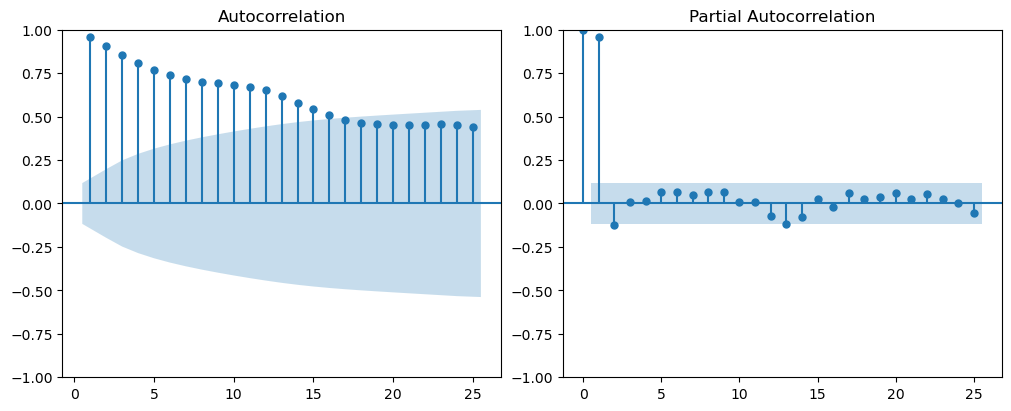

In [30]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(train['Unemployment'], ax = ax1, zero = False)
sm.graphics.tsa.plot_pacf(train['Unemployment'], method = 'ywm', ax = ax2)
plt.show()

#### Модель без константы и тренда с учетом аддитивных выбросов

Вместо нее хорошо работает модель sARMA(1,1) без учета выбросов с регрессором ct

In [328]:
mod_m = sm.tsa.statespace.SARIMAX(train['Unemployment'], trend='n', 
                                  order=(2,0,0), 
                                  seasonal_order=(1,0,0,12), 
                                  exog=train[['COVID_dummy', '2008_dummy']]
                                 )
results = mod_m.fit(disp = False)
print(results.summary())

#экзогенные переменные хорошо работают только с регрессором с                                  

                                     SARIMAX Results                                      
Dep. Variable:                       Unemployment   No. Observations:                  279
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -24.827
Date:                            Tue, 03 Jun 2025   AIC                             61.654
Time:                                    16:12:43   BIC                             83.441
Sample:                                         0   HQIC                            70.394
                                            - 279                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
COVID_dummy          0   2574.739          0      1.000   -5046.395    5046.395
2008_dummy     -0.0354      0.18

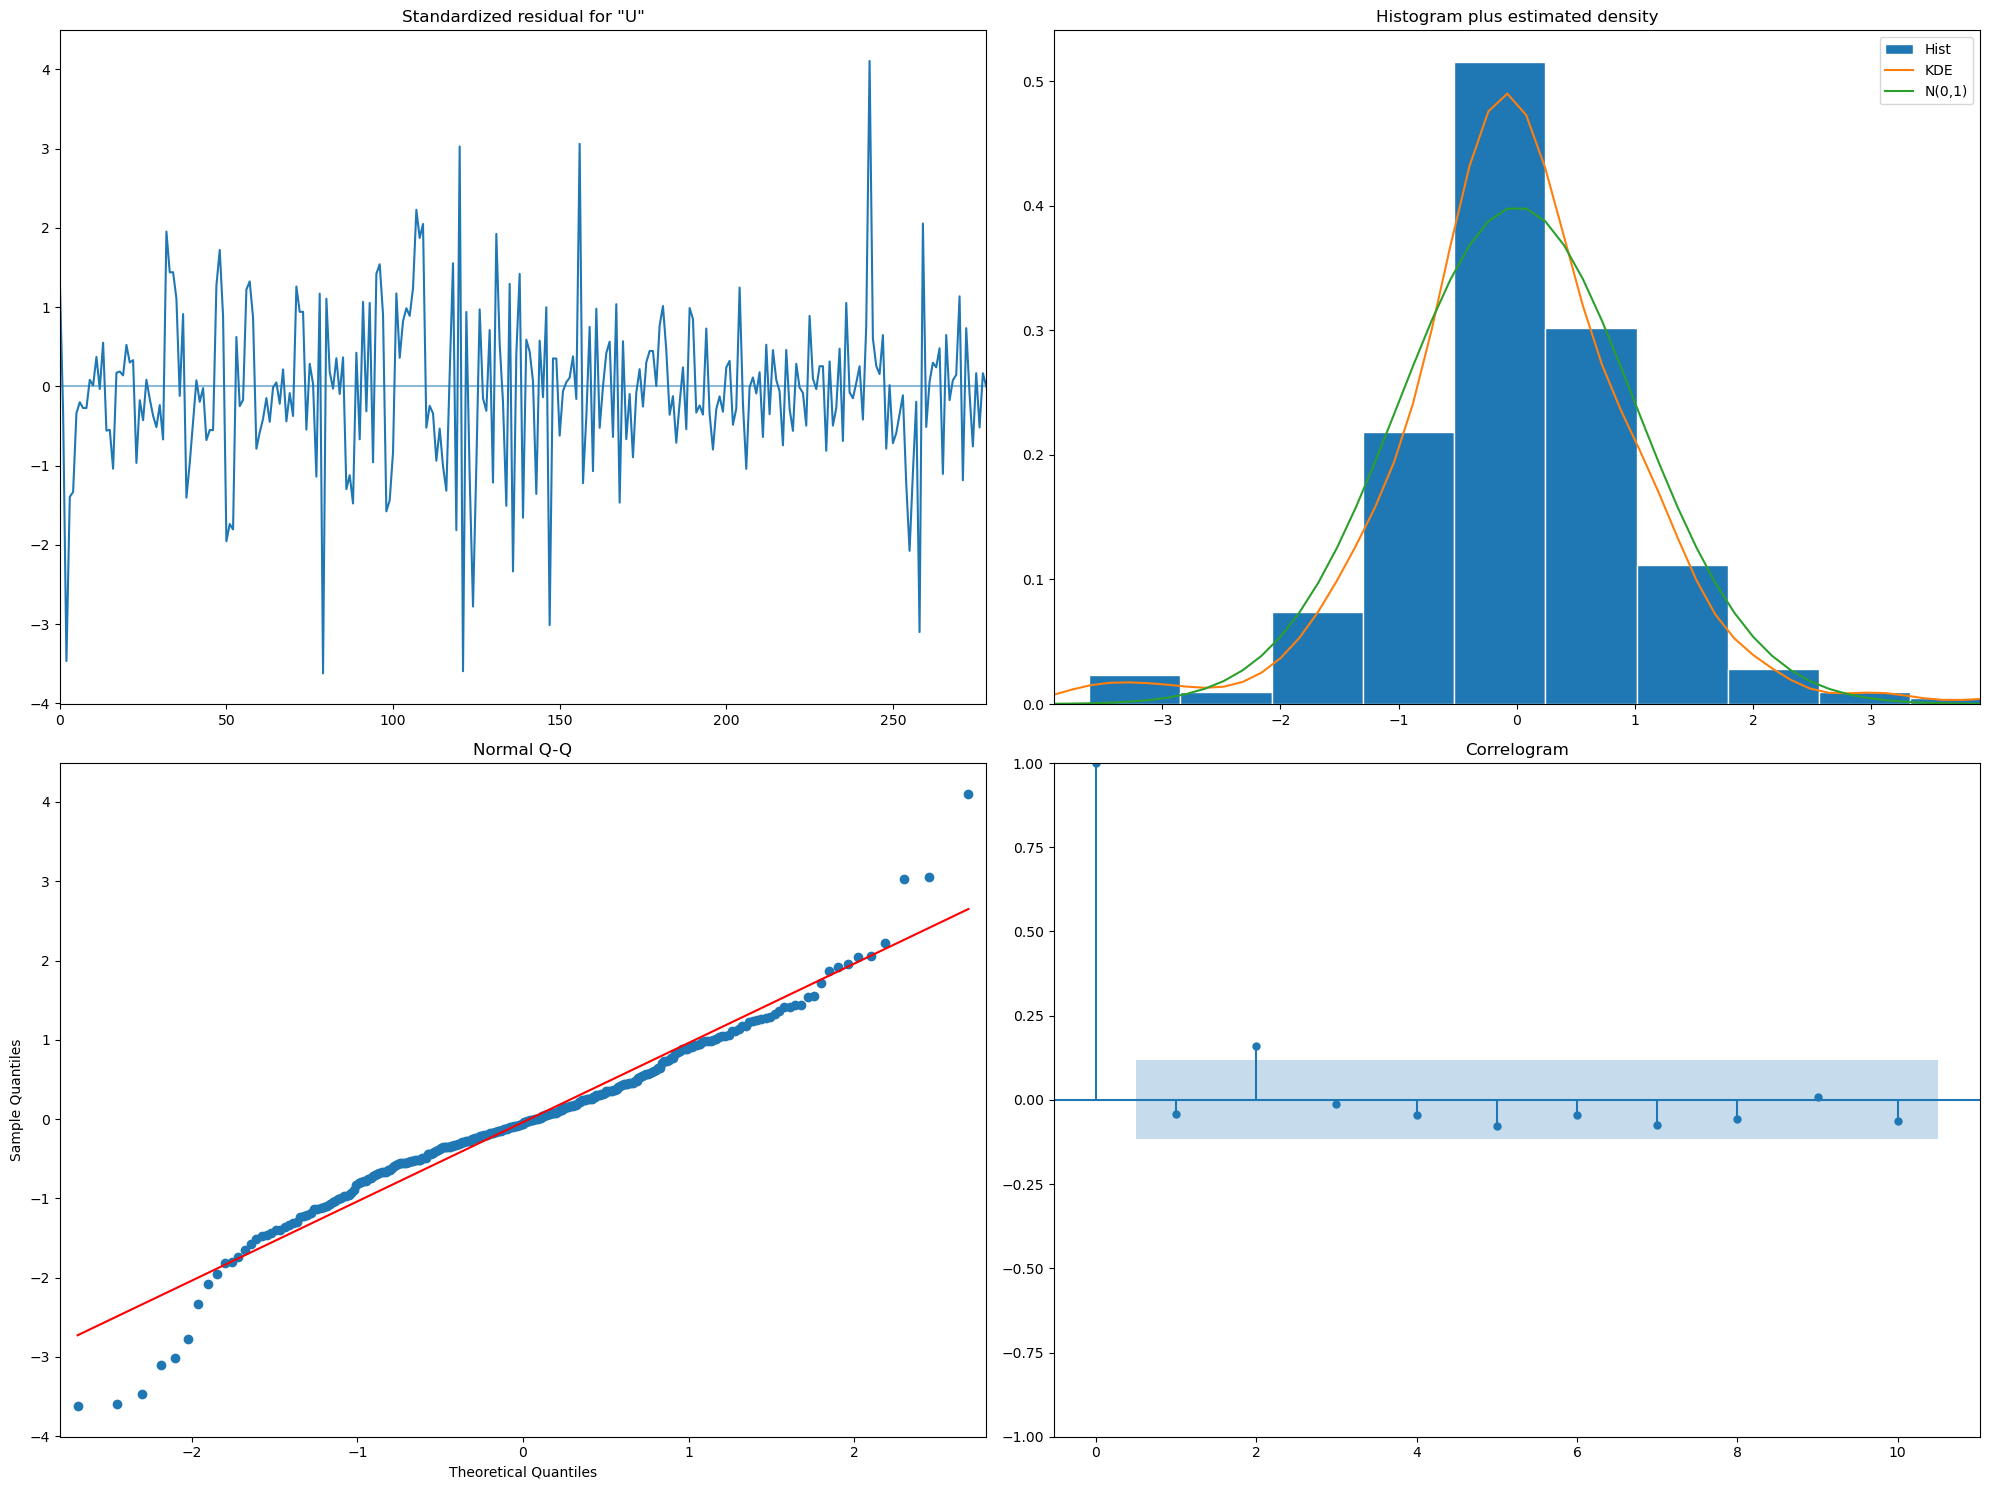

In [329]:
results.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

p-value = 0.9993


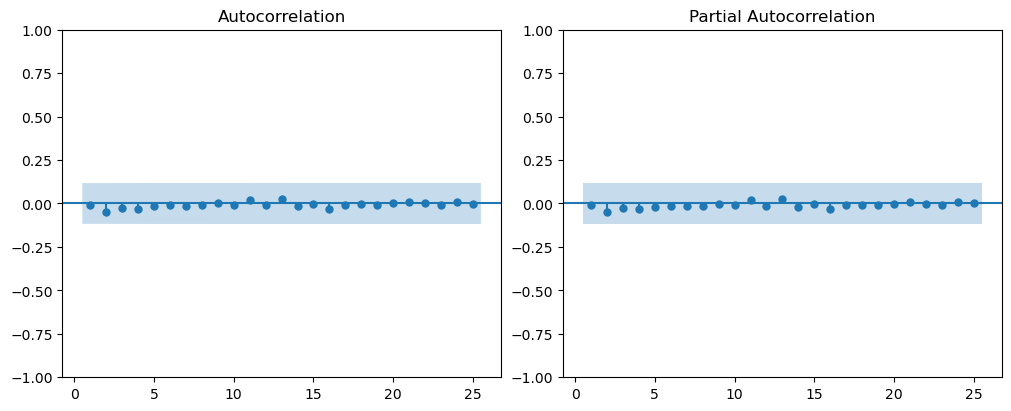

In [330]:
# H0: нет корреляций в остатках
print('p-value =', np.round(bgtest(results, nlags = 12)[1], 4))
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(results.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(results.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

Тест Бройша-Годфри не отвергает нулевую гипотезу об отсутствии корреляции в остатках (р > 0.05) => остатки некоррелированы. 

**Запись модели**: 

### $X_t=0.0320 -0.0002*t + 0.9389X_{t-1} -0.0184X_{t-2} +0.9554X_{t-12} -0.6920e_{t-12} + e_t$

**Скорректировать коэффициенты**

## Подбор параметров p, d, q - анализ acf/pacf

**ACF**: Определяет q (порядок МА).
- Если ACF обрывается после лага q => q=q.

**PACF**: Определяет p (порядок AR):
- Если PACF обрывается после лага p => р=р.

Смотрим модель ARIMA:

    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(data, order=(p, d, q))
    results = model.fit()
    residuals = results.resid

**Проверка Автокорреляции остатков - тест Льюинга-Бокса (вместо него можно Б-Г)**:

    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(lb_test)

- Если p-value > 0.05 -> остатки независимы (хорошо).

**Графики остатков**:

    plot_acf(residuals, lags=20)
    plot_pacf(residuals, lags=20)

- Если нет "выскочек" -> модель адекватна.

## ???Когда и что проверять???

1. Предварительный этап: Стационарность, тренд, сезонность:

- ADF, KPSS, визуализация.

2. Подбор параметров: Порядок AR(p), MA(q):

- ACF/PACF.

3. Дигностика остатков: Автокорреляция, нормальность, гетероскедастичность:

- ACF/PACF и Ljung-Box - остатки. Если есть проблема - увеличиваем p и q.
- Breusch-Pagan (для больших выборок) - гетероскедастичность. Если есть проблема - взвешенный МНК или GARCH.
- Шапиро-Уилка или Гистограмма и Q-Q plot - нормальность остатков. Если есть проблема - Box-Cox преобразование.

# 2 ЭТАП

## Оценка модели, обоснование выбора.

1. Подобранные параметры использовать для модели, обучить модель.
    
-    Для ARIMA

    model_arima = ARIMA(data, order=(p, d, q)).fit()

-    Для SARIMA
    
    model_sarima = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

2. Изучить summary():

- Коэффициенты AR/MA/SAR/SMA должны иметь p-value < 0.05.
- Незначимые коэффициенты (например, p-value > 0.1) исключить и перестройть модель.

3. Диагностика остатков (см. выше).

Нужно словами прописать, что мы получили, почему мы взяли именно эти p, d, q, какие цифры в результатах тестов и на графиках сказали нам об этом и т.п.

4. Сравнение моделей через информационные критерии

! Выбать модель с наименьшими AIC/BIC:

    print(f"ARIMA AIC: {model_arima.aic:.2f}, BIC: {model_arima.bic:.2f}")
    print(f"SARIMA AIC: {model_sarima.aic:.2f}, BIC: {model_sarima.bic:.2f}")

!!! Разница в AIC/BIC > 2 означает существенное улучшение.

## Зарплаты

Здесь рассмотрим несколько комбинаций параметорв для модели, чтобы выбрать лучшую (она уже записана выше в пункте 1). Предполагается, что d=1.

1. SARIMA(0,1,1)(0,1,1,12) с const и трендом -> ...
2. SARIMA(1,1,1)(1,1,1,12) c const  -> ...
3. SARIMA(0,1,1)(0,1,1,12) c const и трендом -> ...

**ДОРАБОТАТЬ ПАРАМЕТРЫ**

## Безработица (аналогично)

Здесь рассмотрим несколько комбинаций параметорв для модели, чтобы выбрать лучшую (она уже записана выше в пункте 1). Предполагается, что d=1.

1. SARIMA(1,0,0)(1,0,1,12) с const и трендом -> ...
2. SARIMA(2,0,0)(1,0,1,12) c const и трендом -> ...
3. SARIMA(2,0,0)(2,0,0,12) с const -> ...

**ДОРАБОТАТЬ ПАРАМЕТРЫ**

## ИТОГО 

**Модель для зарплат**:
...

**Модель для безработицы**:
...

## STL для зарплат вместо дамми (для примера)

Окажется, что после преобразований acf и pacf все равно вылезают за доверительный интервал, хотя и не так сильно, как перед подбором параметров модели.

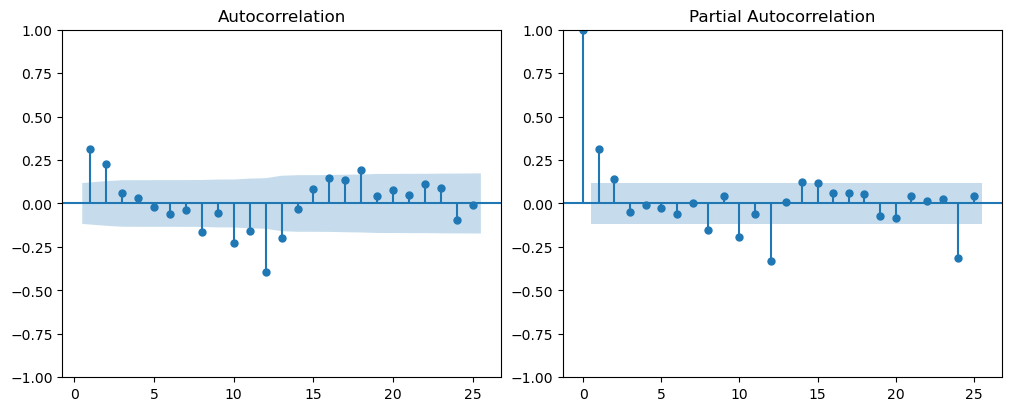

In [280]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(train['dif'], ax = ax1, zero = False)
sm.graphics.tsa.plot_pacf(train['dif'], method = 'ywm', ax = ax2)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                    dif   No. Observations:                  278
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 912.896
Date:                Tue, 03 Jun 2025   AIC                          -1817.793
Time:                        15:34:57   BIC                          -1803.282
Sample:                             0   HQIC                         -1811.971
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.671      0.502      -0.001       0.001
ar.L1          0.2742      0.055      5.027      0.000       0.167       0.381
ar.L2          0.1393      0.060      2.333      0.0

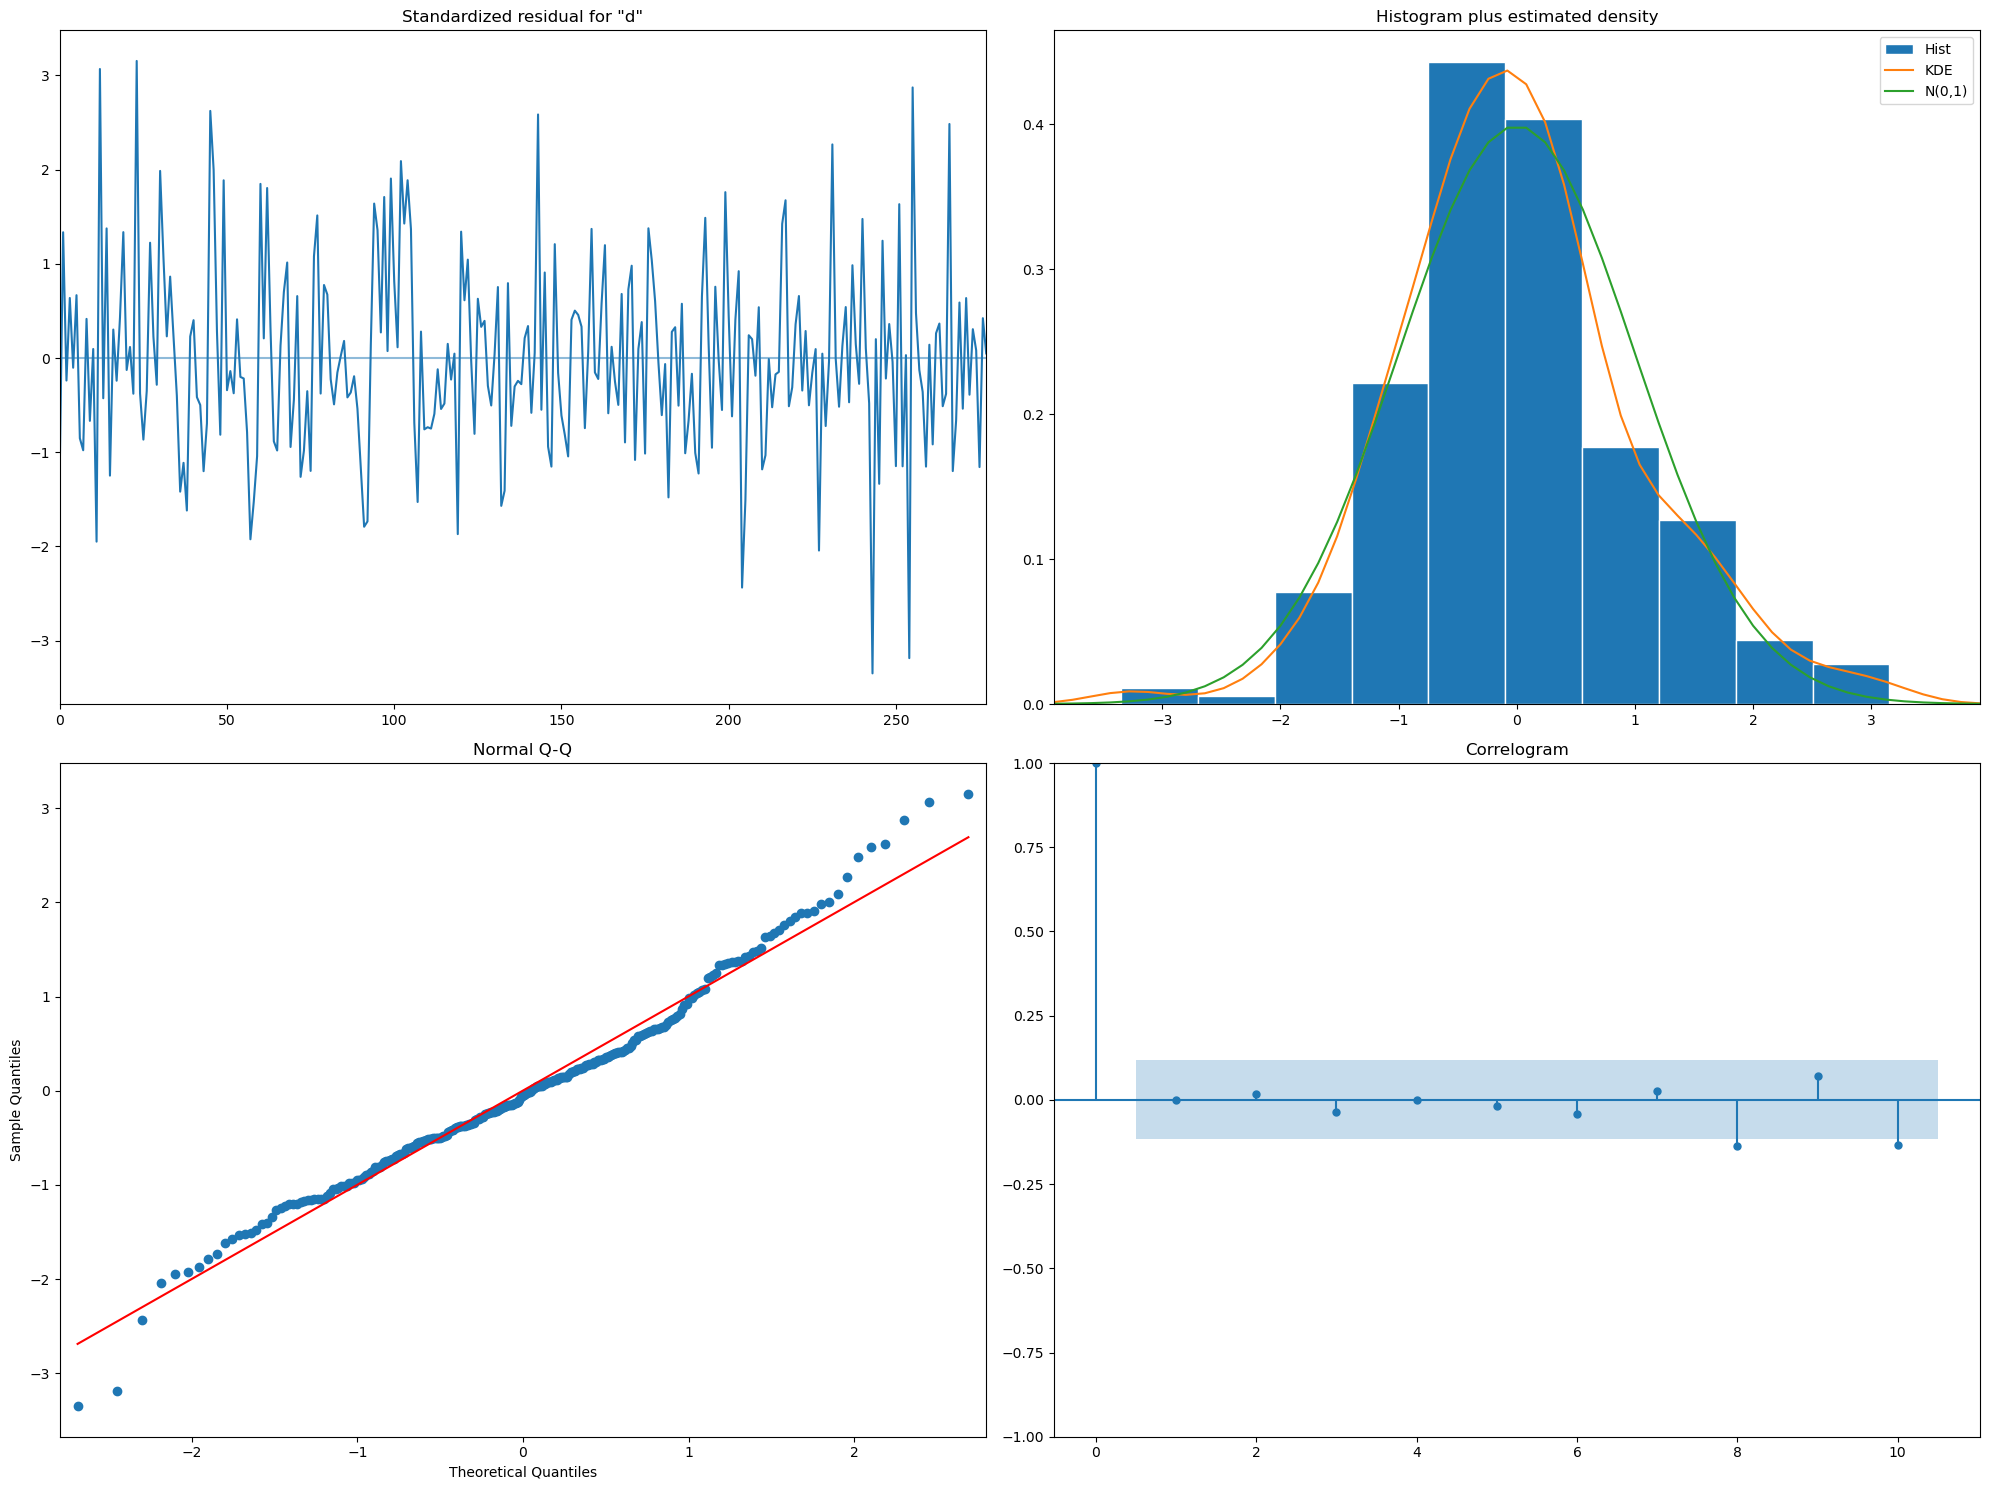

In [282]:
# STL-разложение (period=12 для месячных данных)
stl = STL(train['Wages'], period=12).fit()

# Удаляем и тренд, и сезонность, оставляя только остатки
train['dif'] = stl.resid

mod_m = sm.tsa.statespace.SARIMAX(train['dif'], trend='c', order=(2,0,0))#, seasonal_order=(1,0,0,12))
results = mod_m.fit(disp = False)
print(results.summary())

print('p-value =', np.round(bgtest(results, nlags = 6)[1], 3))
results.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

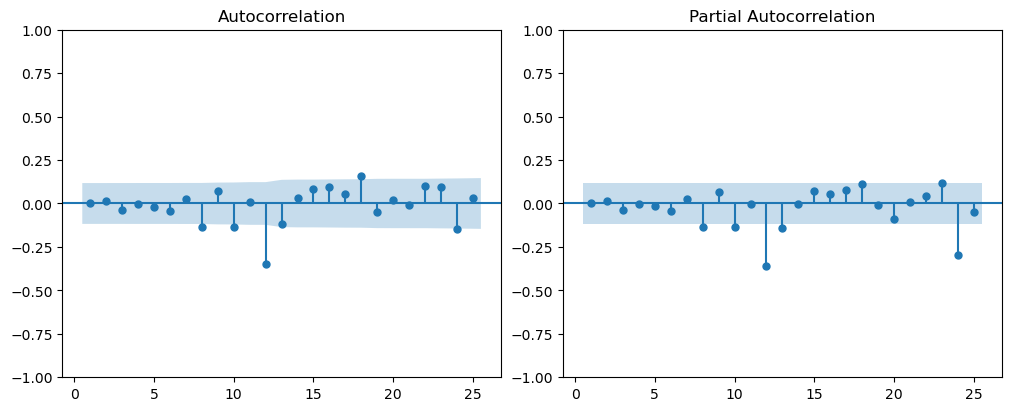

In [283]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)
sm.graphics.tsa.plot_acf(results.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(results.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()

# 3 ЭТАП

В целом, тестирование - это все то, что проделалось в предыдущем пункте: анализ остатков (они должны вести себя как белый шум), нормальность распределения и гетероскедастичность; коэффициенты модели должны быть статистически значимы (P > |z| (p-value) < 0.05 для всех коэффициентов, кроме константы (есмли она незначима)).

# 4 ЭТАП

# Прогнозы.

1. Делим данные на train и test
2. Считаем прогноз для обученной на train модели. Считаем предикты, доверительные интервалы. Визуализируем.
3. Считаем метрики. MAPE:
- < 5%: Отличная точность.
- 5–10%: Хорошая точность.
- 10%: Низкая точность.
4. Анализ остатков.
- График остатков - разница между реальными и прогнозируемыми значениями. Остатки должны колебаться вокруг нуля без паттернов.
- Автокорреляция остатков. Не должно быть значимых лагов.
5. Вывод.

## Wages

In [44]:
wages['diff']=wages['Wages'].diff().dropna()
wages.dropna(axis=0)

,Dates,Wages,diff
121,2000-02-01,7.516977,0.004906
122,2000-03-01,7.609862,0.092885
123,2000-04-01,7.620215,0.010353
124,2000-05-01,7.650169,0.029954
125,2000-06-01,7.738052,0.087884
...,...,...,...
417,2024-10-01,11.368847,0.026425
418,2024-11-01,11.366731,-0.002116
419,2024-12-01,11.764967,0.398236
420,2025-01-01,11.396178,-0.368789


In [224]:
dum = pd.get_dummies(wages['Dates'].dt.month, dtype=float)
wages = pd.concat([wages, dum], axis=1)
wages.iloc[:,2:]

,1,2,3,4,5,6,7,8,9,10,...,3,4,5,6,7,8,9,10,11,12
120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
# Определяем границу разделения (последние 12 месяцев)
split_date = wages['Dates'].max() - pd.DateOffset(months=24)

# Разделяем данные
train = wages[wages['Dates'] <= split_date].copy()
test = wages[wages['Dates'] > split_date].copy()

print(f"Обучающая выборка: {train['Dates'].min()} - {train['Dates'].max()}")
print(f"Тестовая выборка: {test['Dates'].min()} - {test['Dates'].max()}")
print(f"Размеры: train={len(train)}, test={len(test)}")

Обучающая выборка: 2000-01-01 00:00:00 - 2023-02-01 00:00:00
Тестовая выборка: 2023-03-01 00:00:00 - 2025-02-01 00:00:00
Размеры: train=278, test=24


In [46]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    # Фильтруем нулевые значения, чтобы избежать деления на ноль
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]
    return np.mean(np.abs((actual - predicted) / actual)) *100


                               SARIMAX Results                                
Dep. Variable:                  Wages   No. Observations:                  278
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 626.188
Date:                Tue, 03 Jun 2025   AIC                          -1216.377
Time:                        14:44:54   BIC                          -1151.144
Sample:                             0   HQIC                         -1190.203
                                - 278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0411      0.004      9.328      0.000       0.032       0.050
drift         -0.0001   2.36e-05     -5.387      0.000      -0.000   -8.08e-05
1             -0.0595      0.006    -10.780      0.0

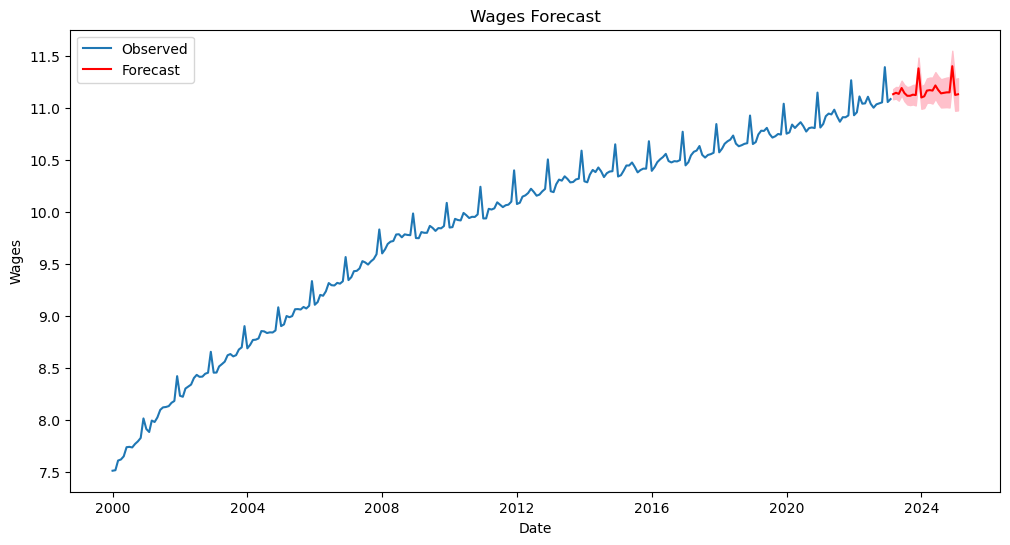

In [229]:
mod_m1 = sm.tsa.statespace.SARIMAX(train['Wages'], 
                                   trend='ct', 
                                   order=(1, 1, 2),
                                   exog=train.iloc[:,2:]
                                   # seasonal_order=(1, 1, 1, 12),
                                  )
results1 = mod_m1.fit(disp=False)
print(results1.summary())


forecast_periods = 24  # Forecast the next 24 months
forecast = results1.get_forecast(steps=forecast_periods, exog=test.iloc[:,2:])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

mape = calculate_mape(test['Wages'], forecast_mean)
print(f"MAPE на тесте: {mape:.2f}%")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Dates'],train['Wages'], label='Observed')
plt.plot(test['Dates'], forecast_mean, label='Forecast', color='red')
plt.fill_between(test['Dates'].values, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Wages Forecast")
plt.xlabel("Date")
plt.ylabel("Wages")
plt.legend()
plt.show()

In [230]:
test['Wages'].values - forecast_mean.values

array([0.04453274, 0.0292793 , 0.06297981, 0.05640517, 0.03477272,
       0.0331958 , 0.05394191, 0.0836963 , 0.08121371, 0.17169334,
       0.12687955, 0.16000456, 0.21726612, 0.1674105 , 0.20120159,
       0.18345672, 0.17893348, 0.17870641, 0.19887901, 0.2208126 ,
       0.21827433, 0.3653377 , 0.27301801, 0.27397939])

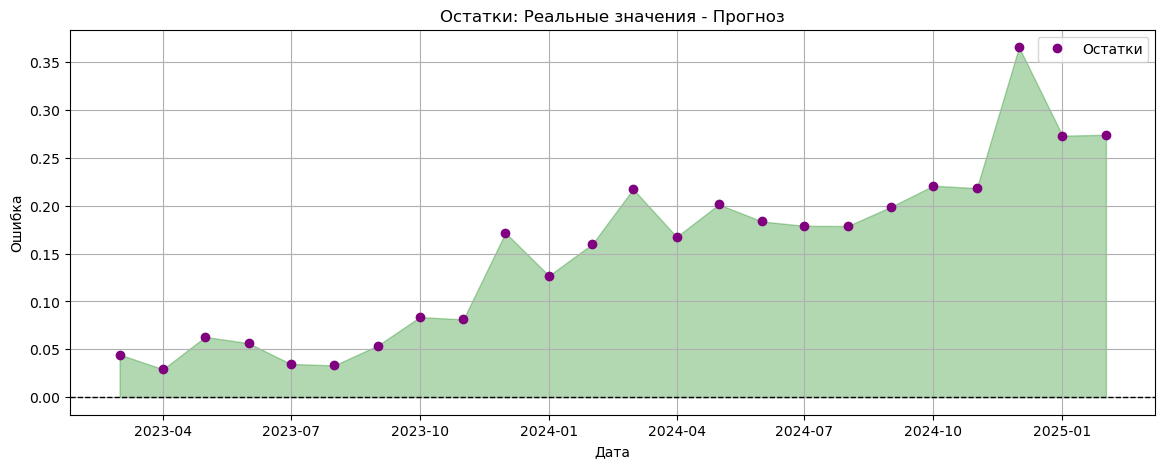

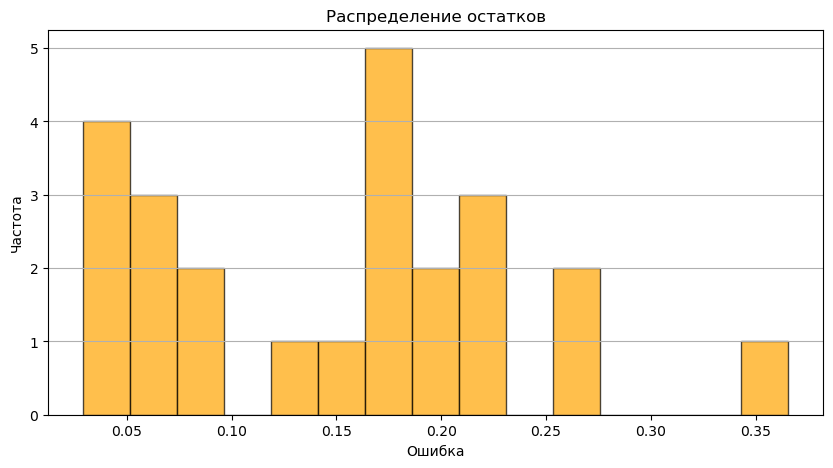

In [231]:
residuals = test['Wages'].values - forecast_mean.values

plt.figure(figsize=(14, 5))
plt.plot(test['Dates'].values, residuals, marker='o', linestyle='', color='purple', label='Остатки')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.fill_between(test['Dates'].values, residuals, where=(residuals > 0), color='green', alpha=0.3)
plt.fill_between(test['Dates'].values, residuals, where=(residuals < 0), color='red', alpha=0.3)
plt.title('Остатки: Реальные значения - Прогноз')
plt.xlabel('Дата')
plt.ylabel('Ошибка')
plt.legend()
plt.grid()
plt.show()

# 4. Гистограмма остатков
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=15, color='orange', alpha=0.7, edgecolor='black')
plt.title('Распределение остатков')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()


## Безработица - тут плохие прогнозы, надо докручивать модель

In [50]:
# Определяем границу разделения (последние 12 месяцев)
split_date = unemployment['Dates'].max() - pd.DateOffset(months=24)

# Разделяем данные
train = unemployment[unemployment['Dates'] <= split_date].copy()
test = unemployment[unemployment['Dates'] > split_date].copy()

print(f"Обучающая выборка: {train['Dates'].min()} - {train['Dates'].max()}")
print(f"Тестовая выборка: {test['Dates'].min()} - {test['Dates'].max()}")
print(f"Размеры: train={len(train)}, test={len(test)}")

Обучающая выборка: 2000-01-01 00:00:00 - 2023-03-01 00:00:00
Тестовая выборка: 2023-04-01 00:00:00 - 2025-03-01 00:00:00
Размеры: train=279, test=24


                                      SARIMAX Results                                       
Dep. Variable:                         Unemployment   No. Observations:                  279
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -17.092
Date:                              Tue, 03 Jun 2025   AIC                             50.183
Time:                                      10:36:32   BIC                             78.851
Sample:                                           0   HQIC                            61.700
                                              - 279                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0165      0.025      0.658      0.511      -0.033       0.066
drift          -

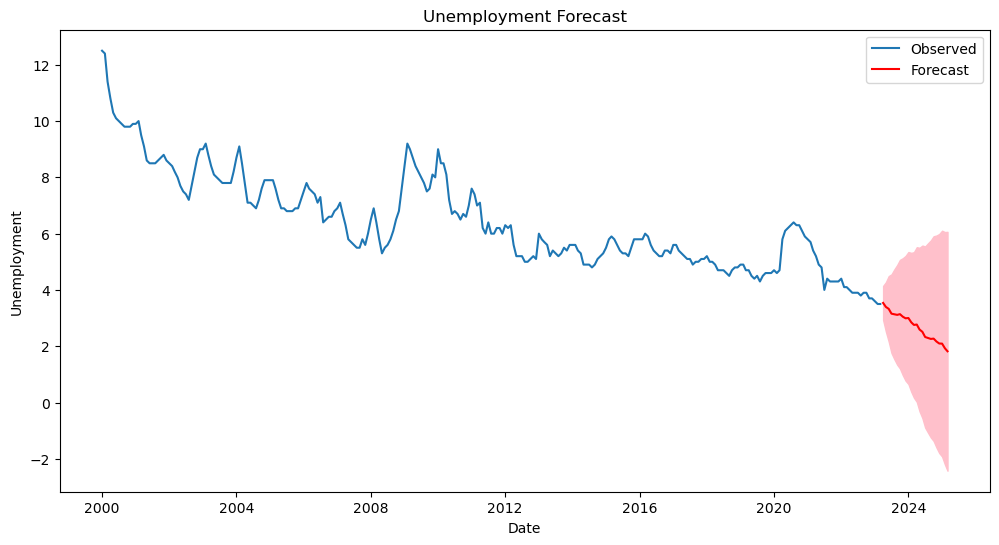

In [51]:
mod_m = sm.tsa.statespace.SARIMAX(train['Unemployment'], trend='ct', 
                                  order=(0,1,2), 
                                  seasonal_order=(0,1,1,12), 
                                  exog=train[[
                                      'COVID_dummy', 
                                      '2008_dummy'
                                  ]]
                                 )
results = mod_m.fit(disp = False)
print(results.summary())

forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods, 
                                exog=test[[
                                    'COVID_dummy', 
                                    '2008_dummy'
                                ]]
                               )
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

mape = calculate_mape(test['Unemployment'], forecast_mean)
print(f"MAPE на тесте: {mape:.2f}%")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Dates'],train['Unemployment'], label='Observed')
plt.plot(test['Dates'], forecast_mean, label='Forecast', color='red')
plt.fill_between(test['Dates'].values, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Unemployment Forecast")
plt.xlabel("Date")
plt.ylabel("Unemployment")
plt.legend()
plt.show()

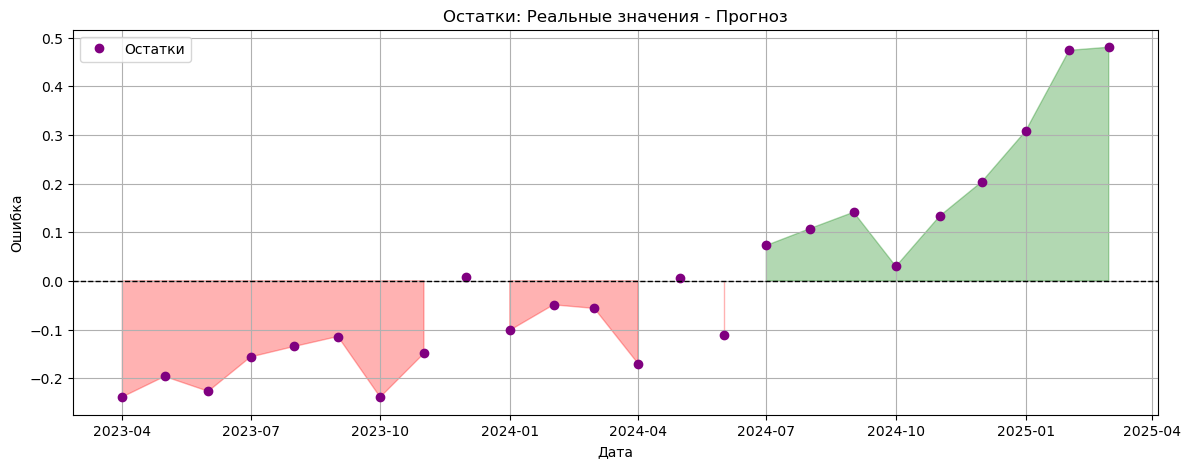

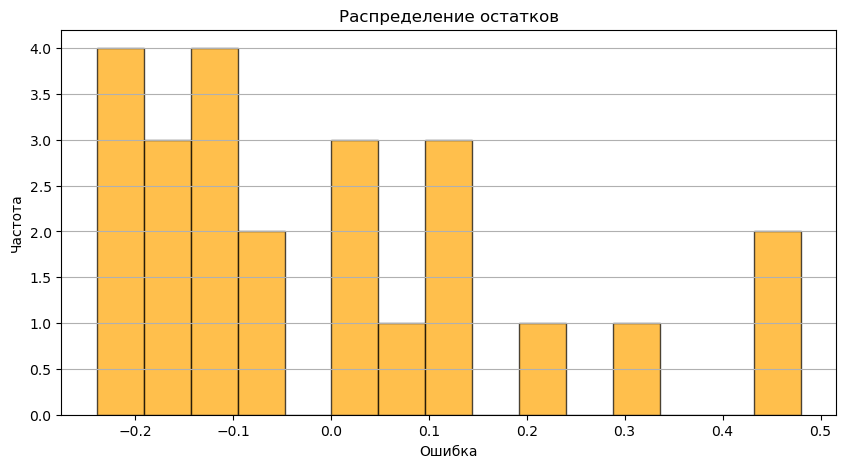

In [52]:
residuals = test['Unemployment'].values - forecast_mean.values

plt.figure(figsize=(14, 5))
plt.plot(test['Dates'].values, residuals, marker='o', linestyle='', color='purple', label='Остатки')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.fill_between(test['Dates'].values, residuals, where=(residuals > 0), color='green', alpha=0.3)
plt.fill_between(test['Dates'].values, residuals, where=(residuals < 0), color='red', alpha=0.3)
plt.title('Остатки: Реальные значения - Прогноз')
plt.xlabel('Дата')
plt.ylabel('Ошибка')
plt.legend()
plt.grid()
plt.show()

# 4. Гистограмма остатков
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=15, color='orange', alpha=0.7, edgecolor='black')
plt.title('Распределение остатков')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

# Тест Дики-Фуллера, тестирование коинтеграции; VAR

### 1. Тестирование коинтеграции

Цель: Проверить, есть ли долгосрочная связь между нестационарными рядами.

1. Тест Энгла-Грейнджера (Engle-Granger):
- Оценить регрессию :
  ### $Wages_t=β_0 +β_1Unemployment_t + e_t$

- Провести ADF тест для остатков еt.
  
  Если p-value < 0.05: Ряды коинтегрированы.

2. Интерпретация.
- Коинтеграция есть: Между рядами существует долгосрочное равновесие (можно строить VECM).
- Коинтеграции нет: Используем VAR в первых разностях.



In [177]:
data = pd.merge(wages[['Dates','Wages']], unemployment[['Dates','Unemployment']], on='Dates', how='inner')
data = data.set_index('Dates')
data.head()

,Wages,Unemployment
Dates,,
2000-01-01,7.512071,12.5
2000-02-01,7.516977,12.4
2000-03-01,7.609862,11.4
2000-04-01,7.620215,10.8
2000-05-01,7.650169,10.3


In [54]:
# Оцениваем регрессию
X = sm.add_constant(data['Unemployment'])  # Добавляем константу
model = sm.OLS(data['Wages'], X).fit()
print(model.summary())

# Получаем остатки регрессии
residuals = model.resid

                            OLS Regression Results                            
Dep. Variable:                  Wages   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1261.
Date:                Tue, 03 Jun 2025   Prob (F-statistic):          1.78e-109
Time:                        10:36:33   Log-Likelihood:                -179.81
No. Observations:                 302   AIC:                             363.6
Df Residuals:                     300   BIC:                             371.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.8504      0.086    149.890   

Коэффициент у безработицы значим (p-value < 0.05), это указывает на связь.

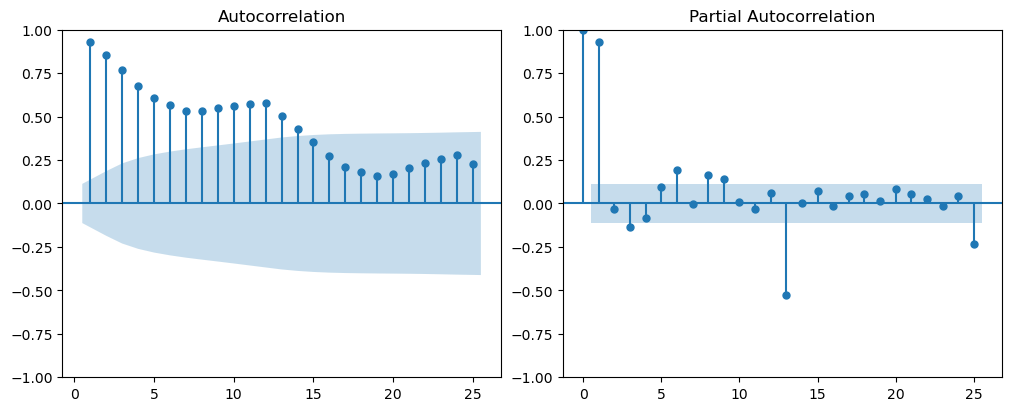

In [58]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(residuals, ax = ax1, zero = False)
sm.graphics.tsa.plot_pacf(residuals, method = 'ywm', ax = ax2)
plt.show()

# Другой вариант - как на семе углубы

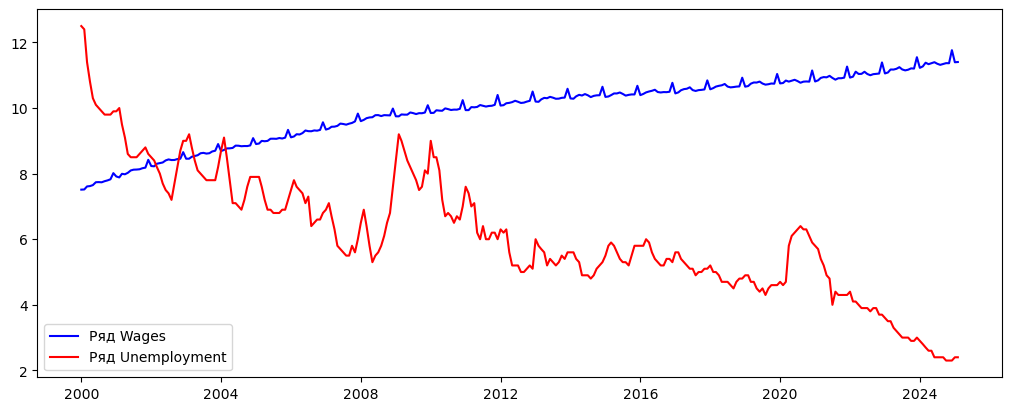

In [86]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)
ax.plot(data['Wages'],'b-', label = 'Ряд Wages')
ax.plot(data['Unemployment'],'r-', label = 'Ряд Unemployment')
ax.legend()
plt.show()

In [180]:
adf_test(data['Wages'], regression = 'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -2.399573
p-value                          0.379846
#Lags Used                      13.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.990553
Critical Value (5%)             -3.425845
Critical Value (10%)            -3.136076
dtype: float64


In [181]:
kpss_test(data['Wages'], regression = 'ct')

Results of KPSS Test:
Test Statistic            0.63564
p-value                   0.01000
#Lags Used               10.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64


In [182]:
adf_test(data['Unemployment'], regression = 'ct')

Results of Dickey-Fuller Test:
Test Statistic                  -3.985751
p-value                          0.009212
#Lags Used                      12.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.990442
Critical Value (5%)             -3.425792
Critical Value (10%)            -3.136045
dtype: float64


In [183]:
kpss_test(data['Unemployment'], regression = 'ct')

Results of KPSS Test:
Test Statistic            0.115613
p-value                   0.100000
#Lags Used               10.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


Ряд зарплат - нестационарный

Ряд безработицы - стационарный

Тест Энгла-Грейнджера проводить **нельзя!** Он проводится только на нестационарных рядах.

Можнно преобразвать ряд зарплат в стационарный ряд и построить VAR для двух стационарных рядов или построить ARIMAX с эгзогенной переменной, где стационарный ряд - эгзогенная переменная.

In [244]:
# STL-разложение (period=12 для месячных данных)
stl = STL(data['Wages'], period=12).fit()

# Удаляем и тренд, и сезонность, оставляя только остатки
data['dif'] = stl.resid

data

,Wages,Unemployment,dif
Dates,,,
2001-01-01,7.913155,9.9,0.001616
2001-02-01,7.884200,10.0,-0.002374
2001-03-01,7.994295,9.5,0.009967
2001-04-01,7.980366,9.1,-0.008813
2001-05-01,8.024207,8.6,-0.001727
...,...,...,...
2024-10-01,11.368847,2.3,-0.003494
2024-11-01,11.366731,2.3,-0.002623
2024-12-01,11.764967,2.3,0.015640


In [243]:
adf_test(data['dif'], regression = 'c')

Results of Dickey-Fuller Test:
Test Statistic                  -5.012680
p-value                          0.000021
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [245]:
kpss_test(data['dif'], regression = 'c')

Results of KPSS Test:
Test Statistic           0.132721
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Все супер, ряд стационарный

## VAR - выбор модели

In [246]:
data

,Wages,Unemployment,dif
Dates,,,
2001-01-01,7.913155,9.9,0.001616
2001-02-01,7.884200,10.0,-0.002374
2001-03-01,7.994295,9.5,0.009967
2001-04-01,7.980366,9.1,-0.008813
2001-05-01,8.024207,8.6,-0.001727
...,...,...,...
2024-10-01,11.368847,2.3,-0.003494
2024-11-01,11.366731,2.3,-0.002623
2024-12-01,11.764967,2.3,0.015640


In [285]:
mod = VAR(data[['Unemployment', 'dif']].dropna())
mod.select_order(maxlags = 12).summary()

,AIC,BIC,FPE,HQIC
0,-8.281,-8.255,0.0002532,-8.271
1,-11.88,-11.80,6.952e-06,-11.85
2,-11.95,-11.82*,6.459e-06,-11.90
3,-11.94,-11.76,6.508e-06,-11.87
4,-11.93,-11.69,6.596e-06,-11.83
5,-11.93,-11.65,6.576e-06,-11.82
6,-11.94,-11.60,6.502e-06,-11.81
7,-11.94,-11.55,6.521e-06,-11.78
8,-11.95,-11.51,6.452e-06,-11.77
9,-11.95,-11.45,6.493e-06,-11.75


Лаги выбираем по наименьшим aic bic

fpe - чем меньше, тем лучше

In [286]:
res_v = mod.fit(2)
print(res_v.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Jun, 2025
Time:                     15:38:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.8489
Nobs:                     288.000    HQIC:                  -11.9252
Log likelihood:           917.253    FPE:                6.29275e-06
AIC:                     -11.9761    Det(Omega_mle):     6.07981e-06
--------------------------------------------------------------------
Results for equation Unemployment
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.097626         0.058410            1.671           0.095
L1.Unemployment         1.272880         0.056815           22.404           0.000
L1.dif                  1.110883         1.71

----------------------------------------------------
Модель в целом хорошо описала данные (высокий log likelihood, низкие AIC/BIC).

### Уравнение для Unemployment (безработица)

Безработица сильно зависит от собственных прошлых значений (L1 положительный, L2 отрицательный).

Зарплаты (dif) статистически не влияют на безработицу (p > 0.05 для L1.dif и L2.dif).

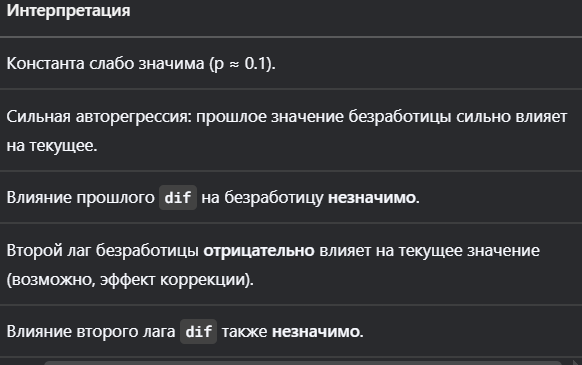

### Уравнение для dif (очищенные зарплаты)

Зарплаты (dif) зависят от своих прошлых значений (L1.dif значим).

Безработица слабо влияет на зарплаты (L1.Unemployment отрицательно, L2.Unemployment положительно, но p ≈ 0.1).

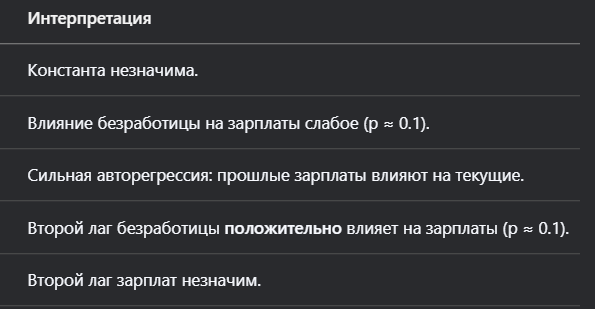

Корреляция остатков между уравнениями очень слабая (-0.053), что хорошо: значит, модели не пропустили важных зависимостей.

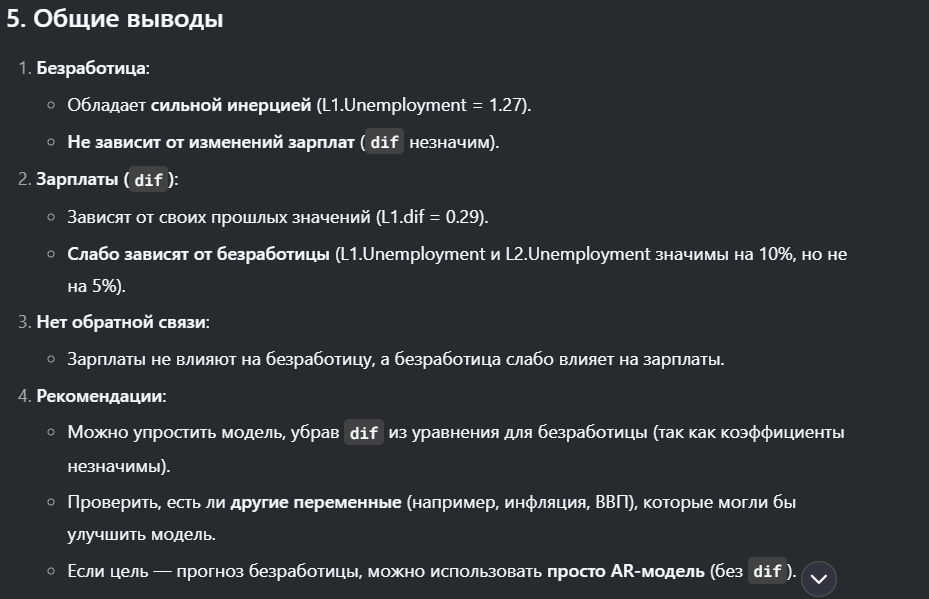
____________________________________________________________

**Диагностика остатков**

In [287]:
res_v.test_normality().summary()

Test statistic,Critical value,p-value,df
151.8,9.488,0.000,4


In [288]:
res_v.test_whiteness(nlags = 8).summary()

Test statistic,Critical value,p-value,df
44.87,36.42,0.006,24


In [289]:
res_v.resid_corr

array([[ 1.        , -0.05299714],
       [-0.05299714,  1.        ]])

## IRF

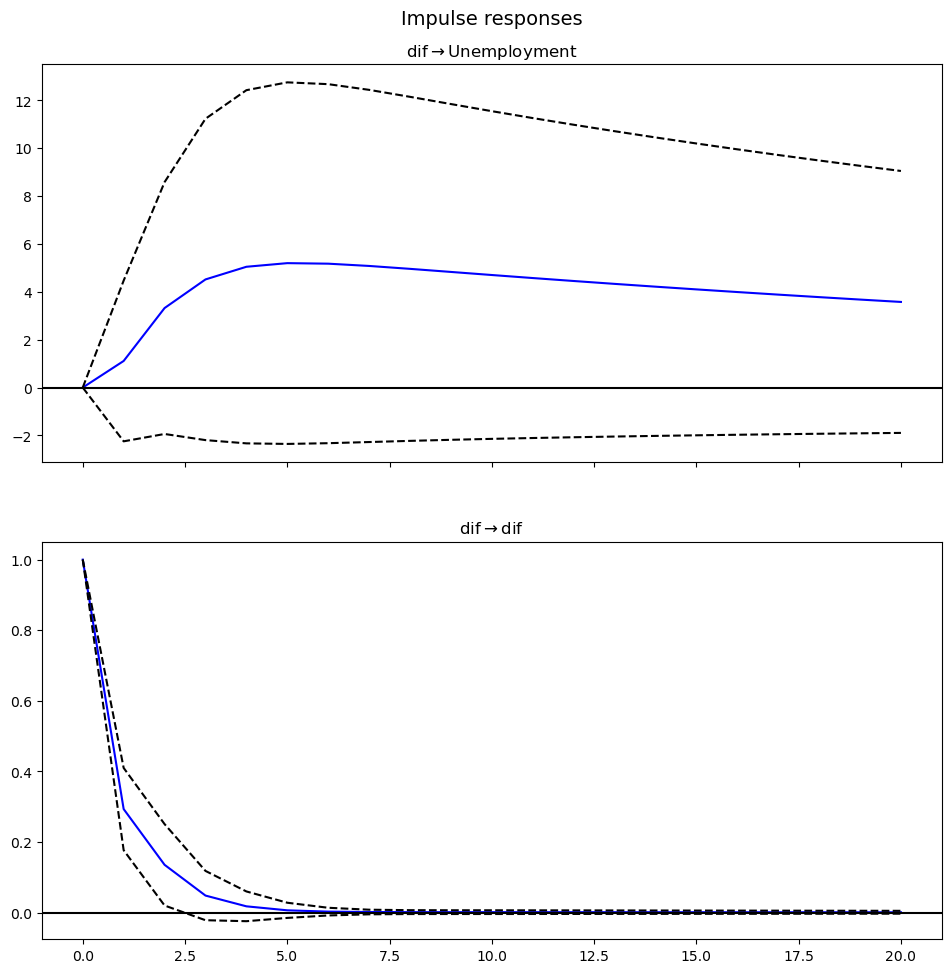

In [290]:
irf = res_v.irf(20)
irf.plot(orth = False, impulse='dif')
plt.show()

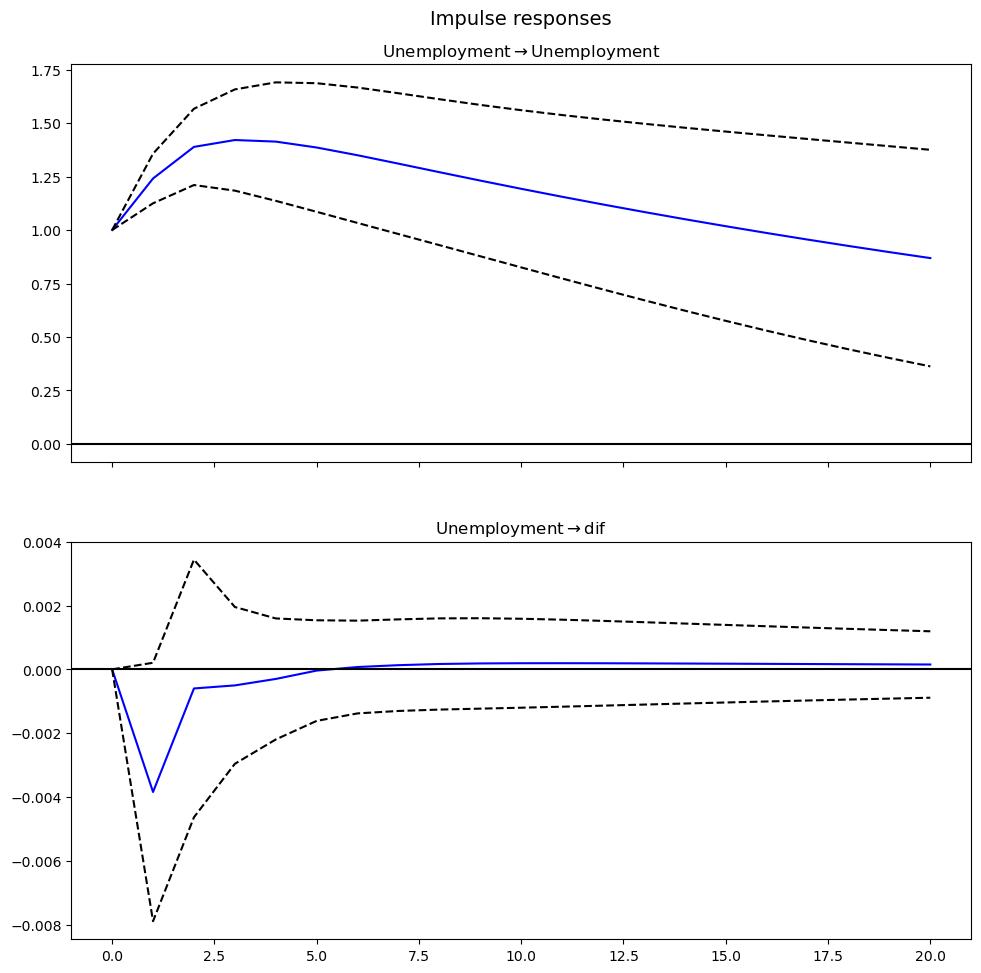

In [253]:
irf = res_v.irf(20)
irf.plot(orth = False, impulse='Unemployment')
plt.show()

## OIRF \ SIRF

In [291]:
mod = VAR(data[['Unemployment','dif']].dropna())
res_v = mod.fit(5)

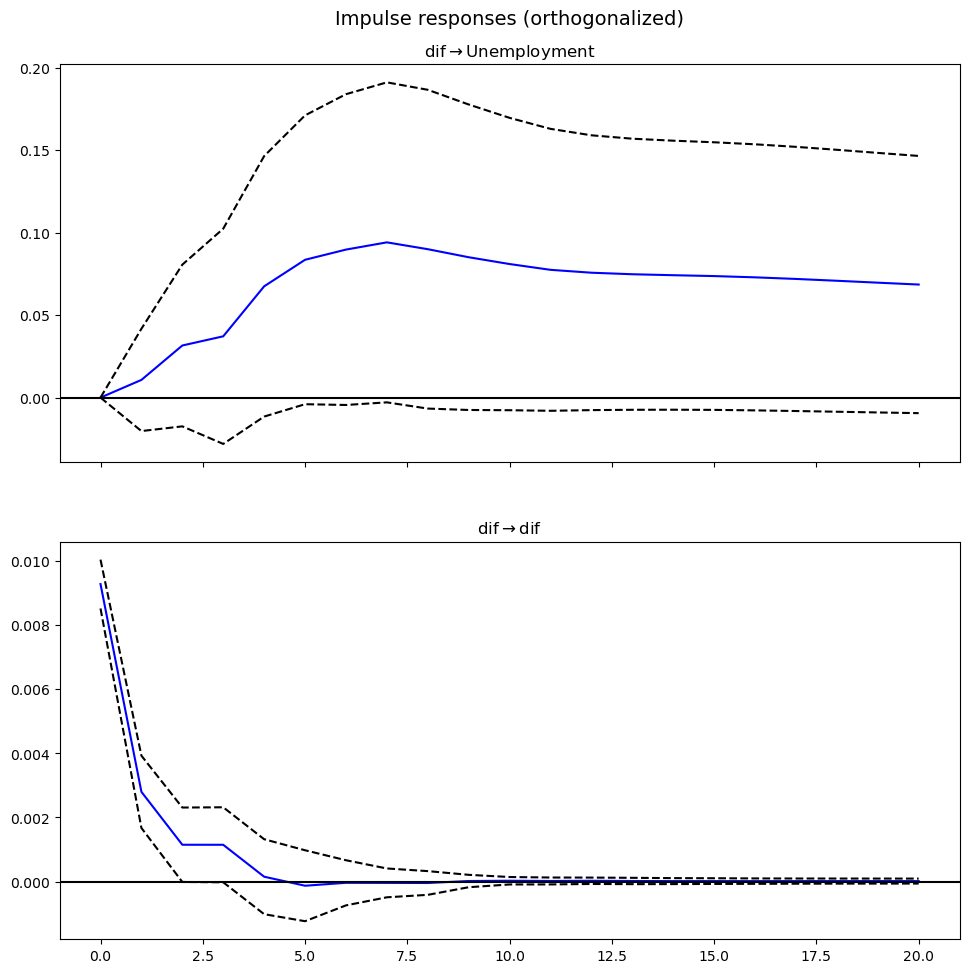

In [292]:
irf = res_v.irf(20)
irf.plot(orth = True, impulse='dif')
plt.show()

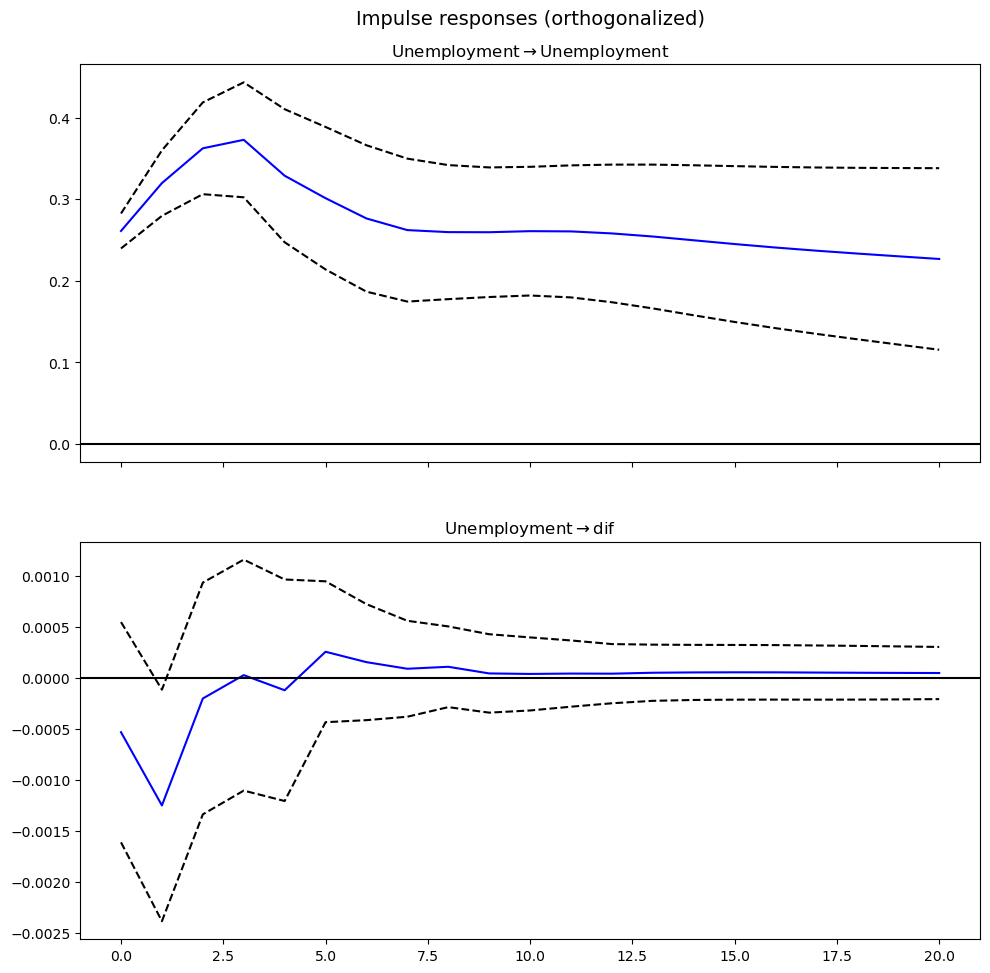

In [293]:
irf = res_v.irf(20)
irf.plot(orth = True, impulse='Unemployment')
plt.show()

# Тест на сезонные единичные корни и структурные сдвиги (то, что дополнительно)

###1. Проверка и моделирование волатильности (ARCH/GARCH).
- Тест на ARCH-эффекты:

    from statsmodels.stats.diagnostic import het_arch
    arch_test = het_arch(residuals)
    print(f"ARCH test p-value: {arch_test[1]:.4f}")

 - p-value < 0.05 → есть кластеры волатильности → строим GARCH.

- Построение GARCH(1,1).
  - alpha[0]: Влияние прошлых шоков.
  - beta[0]: Влияние прошлой волатильности.
  - alpha + beta < 1: Модель стабильна.

###2. Анализ и моделирование сезонности.
- Визуализация. Ищем повторяющиеся пики/спады.
- Сезонная декомпозиция STL/
- SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,12))

###3. Проверка на сезонные единичные корни.

  1) Тест HEGY: Проверяет наличие **сезонных единичных корней**.

  - Проверять при сильной сезонности, особенно если амплитуда колебаний меняется.
  - p-value < 0.05 для сезонных лагов → ряд нестационарен на сезонных частотах.


  2) Сезонное дифференцирование

###4. Обнаружение структурных сдвигов.

  1) **Тесты на структурные сдвиги**:

  - Тест Чоу: Обнаруживает известные точки разрыва.


  2) Включение дамми-переменных


from statsmodels.tsa.stattools import adfuller

def dickey_pantula_test(series, max_d=2): # Если окажется что d>1
    for d in range(max_d, -1, -1):
        diff_series = series.diff(d).dropna() if d > 0 else series
        adf_result = adfuller(diff_series, regression='ct')
        p_value = adf_result[1]
        print(f"Порядок d={d}: p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"Ряд I({d}) — стационарен на 5% уровне.")
            return d
    print("Ряд нестационарен даже после d={max_d} разностей.")
    return max_d

d_order = dickey_pantula_test(wages['Wages_deseasoned'], max_d=20)
print(f"Итоговый порядок интегрирования: d={d_order}")